In [1]:
import numpy as np
from numpy import matlib
import matplotlib.pyplot as plt
import scipy
import matplotlib
import tqdm
from scipy import integrate, fft, sparse
import pandas as pd
import seaborn as sns
import random
import anndata
import os
from sklearn.metrics import confusion_matrix
import loompy as lp

import anndata
import scanpy as sc

from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics.pairwise import cosine_similarity


In [2]:
import sys
import importlib
sys.path.insert(0, '/home/tchari/monod/src/')

In [3]:
import monod
#importlib.reload(monod)
from monod import preprocess, extract_data, cme_toolbox, inference, analysis, mminference

In [4]:
import warnings
warnings.filterwarnings('ignore', category=PendingDeprecationWarning) 

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [6]:
meta_path = "/home/tchari/metadata/"
meta = pd.read_csv(meta_path+'norman_GSE133344_filtered_cell_identities.csv')

#'guide_identity'

In [7]:
# ids = list(meta['guide_identity'].value_counts().index)
# counts = list(meta['guide_identity'].value_counts())

# saveCounts = pd.DataFrame()
# saveCounts['guide_identity'] = ids
# saveCounts['cells'] = counts

In [8]:
#Get top 2k var genes to use, from loom S
ds = lp.connect('/home/tchari/counts/norman_crispr/loom/allcrispr.loom')

In [9]:
spliced = ds.layers['spliced'][:,:]
spliced.shape

(36601, 116844)

In [10]:
gene_names = ds.ra['gene_name']

In [11]:
ds.close()

In [12]:
#Count/log normalize

#Maybe subset for  top genes in matrix with just tested conditions
adata = anndata.AnnData(X = spliced.T)
print(adata)


sc.pp.filter_cells(adata, min_counts=0)
sc.pp.filter_genes(adata, min_counts=0)

sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4) #Cell-size normalization
sc.pp.log1p(adata) #log-variance stabilization

sc.pp.highly_variable_genes(adata,n_top_genes=2000)

genesToKeep = adata.var['highly_variable']
#Get top HVGs

/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  


AnnData object with n_obs × n_vars = 116844 × 36601


In [13]:
# filt_ids = list(set(saveCounts['guide_identity'][saveCounts['cells'] >  1000]).intersection(set(saveCounts['guide_identity'][saveCounts['cells'] <  1170])))
# len(filt_ids)

In [14]:
markers = list(gene_names[genesToKeep])

In [16]:
dataset_meta = ['allcrispr']
print('dataset_meta: ', dataset_meta)
print()

ks = [1,2,3,4,5]
#DUSP9_MAPK1__DUSP9_MAPK1 may have 'multiple transcriptional states'
subcluster_names = [['NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0','DUSP9_MAPK1__DUSP9_MAPK1','CBL_CNN1__CBL_CNN1'],
                    ['NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0','DUSP9_MAPK1__DUSP9_MAPK1','CBL_CNN1__CBL_CNN1'],
                    ['NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0','DUSP9_MAPK1__DUSP9_MAPK1','CBL_CNN1__CBL_CNN1'],
                    ['NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0','DUSP9_MAPK1__DUSP9_MAPK1','CBL_CNN1__CBL_CNN1'],
                    ['NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0','DUSP9_MAPK1__DUSP9_MAPK1','CBL_CNN1__CBL_CNN1'],
                    ['NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0'],['DUSP9_MAPK1__DUSP9_MAPK1'],
                   ['CBL_CNN1__CBL_CNN1']]

sub_names_only = ['_'.join(n) for n in subcluster_names]
for i in range(5):
    sub_names_only[i] = sub_names_only[i]+'_k'+str(ks[i])
    
cluster_names = []
dataset_names = ['norman_'+dataset_meta[0]+'_'+y  for y in sub_names_only]   #To save
print('dataset_names: ', dataset_names)
print('len(dataset_names): ',len(dataset_names))
print()

raw_data_locations = [dataset_meta[0] for y in sub_names_only]
transcriptome_filepath = '/home/tchari/perturbCME/notebooks/gg_200525_genome_polyA_cum_3'

spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'

attribute_names=[(unspliced_layer,spliced_layer),gene_attr,cell_attr]

loom_filepaths = ['/home/tchari/counts/norman_crispr/loom/'+x+'.loom' for x in raw_data_locations] 
print('loom_filepaths: ',loom_filepaths)

n_datasets = len(loom_filepaths)

dataset_meta:  ['allcrispr']

dataset_names:  ['norman_allcrispr_NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0_DUSP9_MAPK1__DUSP9_MAPK1_CBL_CNN1__CBL_CNN1_k1', 'norman_allcrispr_NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0_DUSP9_MAPK1__DUSP9_MAPK1_CBL_CNN1__CBL_CNN1_k2', 'norman_allcrispr_NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0_DUSP9_MAPK1__DUSP9_MAPK1_CBL_CNN1__CBL_CNN1_k3', 'norman_allcrispr_NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0_DUSP9_MAPK1__DUSP9_MAPK1_CBL_CNN1__CBL_CNN1_k4', 'norman_allcrispr_NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0_DUSP9_MAPK1__DUSP9_MAPK1_CBL_CNN1__CBL_CNN1_k5', 'norman_allcrispr_NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0', 'norman_allcrispr_DUSP9_MAPK1__DUSP9_MAPK1', 'norman_allcrispr_CBL_CNN1__CBL_CNN1']
len(dataset_names):  8

loom_filepaths:  ['/home/tchari/counts/norman_crispr/loom/allcrispr.loom', '/home/tchari/counts/norman_crispr/loom/allcrispr.loom', '/home/tchari/counts/norman_crispr/loom/allcrispr.loom', '/home/tchari/counts/norman_crispr/loom/allcrispr.loom', '/home/tchari/counts/n

Dataset allcrispr. 
	116844 barcodes in loom, 94649 pass filter. TTGAACGAGACTCGGA-2CGTTGGGGTGTTTGTG-7GAACCTAAGTGTTAGA-6CCTTCCCTCCGTCATC-4TCAATCTGTCTTTCAT-2TCCCGATGTCTCTTAT-8AAACCTGTCCAGAAGG-2CTGCCTAGTTCCACAA-4GAACCTATCCAGAAGG-3AAGCCGCTCACTCCTG-5TTCTTAGCATGGGAAC-7GACGGCTTCGTCACGG-1TGCGGGTCATTCACTT-8GGACAAGGTAGGGACT-5CGCGGTAGTGAGTATA-8CTGATAGTCACAGGCC-3ACGGAGACAATGGATA-5CATGGCGGTATATGAG-5ACATGGTGTCCAGTAT-5GACCAATTCAACACAC-4AACACGTCATTCTTAC-4CTAGCCTTCAACACGT-4GAACCTAAGCTCTCGG-5GCGCCAAGTGTGACCC-6CGCGGTAAGATAGTCA-1CGTTAGAGTTCGTGAT-8TGCTACCAGCGATTCT-5CGGTTAATCTTCTGGC-5AGACGTTGTCTAGCGC-2TTGGAACTCAAGCCTA-7TCAATCTCATTGAGCT-5CTAACTTCAGACGCTC-5CAACCTCAGGCGACAT-5AGACGTTGTCAAACTC-5CCAATCCAGTCAAGCG-5TACGGATTCGGATGGA-5ACGCCAGTCATCTGCC-5CAGCTGGGTTCGTTGA-4TCGGGACCAATAGCGG-1AACCATGTCTCTGAGA-5ATTATCCAGCGTGTCC-5TATCAGGCAAGCGATG-5AACCGCGCATTGGTAC-3GCGCAGTGTCCAAGTT-5TTGGAACCAGGGAGAG-7ATGCGATAGTACGCGA-5GCGCCAACACACCGCA-8AACGTTGAGCGTAGTG-1CAGCATATCTCAACTT-2TCCCGATGTAAACGCG-5ATGAGGGCATTGGCGC-2TAGGCATCACAGAGGT-

	['NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0', 'DUSP9_MAPK1__DUSP9_MAPK1', 'CBL_CNN1__CBL_CNN1']: 3174 cells in annotations. 3174 in loom. 2868 pass filter.
	['NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0', 'DUSP9_MAPK1__DUSP9_MAPK1', 'CBL_CNN1__CBL_CNN1']: 3174 cells in annotations. 3174 in loom. 2868 pass filter.
	['NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0', 'DUSP9_MAPK1__DUSP9_MAPK1', 'CBL_CNN1__CBL_CNN1']: 3174 cells in annotations. 3174 in loom. 2868 pass filter.
	['NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0', 'DUSP9_MAPK1__DUSP9_MAPK1', 'CBL_CNN1__CBL_CNN1']: 3174 cells in annotations. 3174 in loom. 2868 pass filter.
	['NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0', 'DUSP9_MAPK1__DUSP9_MAPK1', 'CBL_CNN1__CBL_CNN1']: 3174 cells in annotations. 3174 in loom. 2868 pass filter.
	['NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0']: 2536 cells in annotations. 2536 in loom. 2362 pass filter.
	['DUSP9_MAPK1__DUSP9_MAPK1']: 290 cells in annotations. 290 in loom. 260 pass filter.
	['CBL_CNN1__CBL_CNN1']: 348 cells in annotations. 

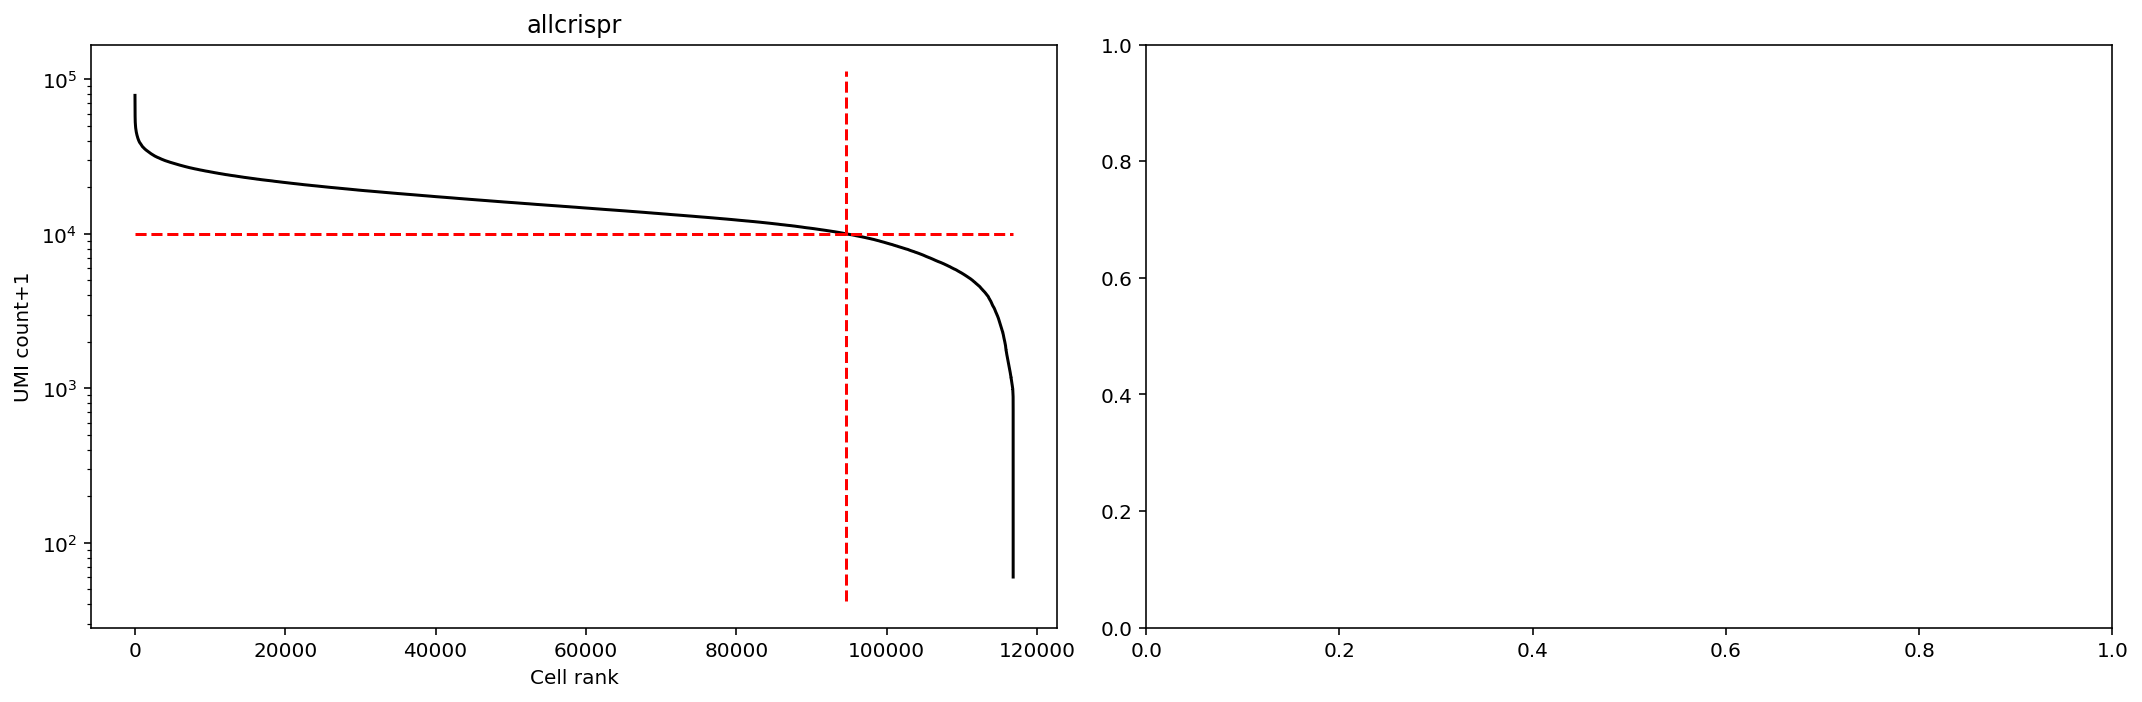

In [17]:
cf = []
thr_lb = [1e4]*len(dataset_meta)*2

fig1,ax1 = plt.subplots(1,len(dataset_meta)*2,figsize=(15,5))

for k in range(len(dataset_meta)):
    filename = loom_filepaths[len(subcluster_names)*k]
    dataset_name = raw_data_locations[len(subcluster_names)*k]
    
    with lp.connect(filename,mode='r') as ds:
        S = ds.layers[spliced_layer][:]
        U = ds.layers[unspliced_layer][:]
        gene_names = ds.ra[gene_attr]
        bcs = ds.ca[cell_attr]
        n_cells = S.shape[1]
        monod.preprocess.knee_plot(S+U,ax1[k],viz=True,thr=thr_lb[k])
        cf_ = ((S+U).sum(0)>thr_lb[k])
        
        n_annot_bcs = meta['cell_barcode'].sum()
        annot_bcs_in_loom = meta['cell_barcode'].isin(bcs).sum()
        annot_bcs_in_filt_loom = meta['cell_barcode'].isin(bcs[cf_]).sum()
        print(f'Dataset {dataset_name}. \n\t{len(bcs)} barcodes in loom, {cf_.sum()} pass filter. {n_annot_bcs} in annotations; of these, {annot_bcs_in_loom} in loom and {annot_bcs_in_filt_loom} in filtered loom.')
        
        #if k==0:
        for subcluster in subcluster_names:
            annot_bcs = meta[(meta['guide_identity'].isin(subcluster))]['cell_barcode']
            cf.append(np.isin(bcs,annot_bcs) & cf_)
            print(f'\t{subcluster}: {len(annot_bcs)} cells in annotations. {np.isin(bcs,annot_bcs).sum()} in loom. {cf[-1].sum()} pass filter.')



    ax1[k].set_title(dataset_name)
    
!mkdir ./figs    
fig_dir = './figs/'
fig_string = fig_dir + 'kneeplots_top_norman_forMM.png'
fig1.tight_layout()
plt.savefig(fig_string,dpi=450)

In [18]:
all_assigns = []
for ind in range(5): 
    all_assigns += [[list(meta['guide_identity'][meta['cell_barcode'] == i])[0] for i in bcs[cf[ind]]]]

In [33]:
uniqs = np.unique(all_assigns)
assigns_dict = dict(zip(uniqs,range(len(uniqs))))


## **Gene Filtering**

In [19]:
import logging, sys
logging.basicConfig(stream=sys.stdout)
log = logging.getLogger()
log.setLevel(logging.INFO)

In [20]:
# !mkdir ./fits


INFO:root:Beginning data preprocessing and filtering.
INFO:root:Directory ./fits/gg_230412_025_norman_crispr_MM_1 already exists.
INFO:root:Dataset: norman_allcrispr_NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0_DUSP9_MAPK1__DUSP9_MAPK1_CBL_CNN1__CBL_CNN1_k1
INFO:root:2868 cells detected.
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:2509 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230412_025_norman_crispr_MM_1/norman_allcrispr_NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0_DUSP9_MAPK1__DUSP9_MAPK1_CBL_CNN1__CBL_CNN1_k1 created.
INFO:root:Dataset: norman_allcrispr_NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0_DUSP9_MAPK1__DUSP9_MAPK1_CBL_CNN1__CBL_CNN1_k2
INFO:root:2868 cells detected.
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:2509 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230412_025_norman_crispr_MM_1/norman_allcrispr_NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0_DU

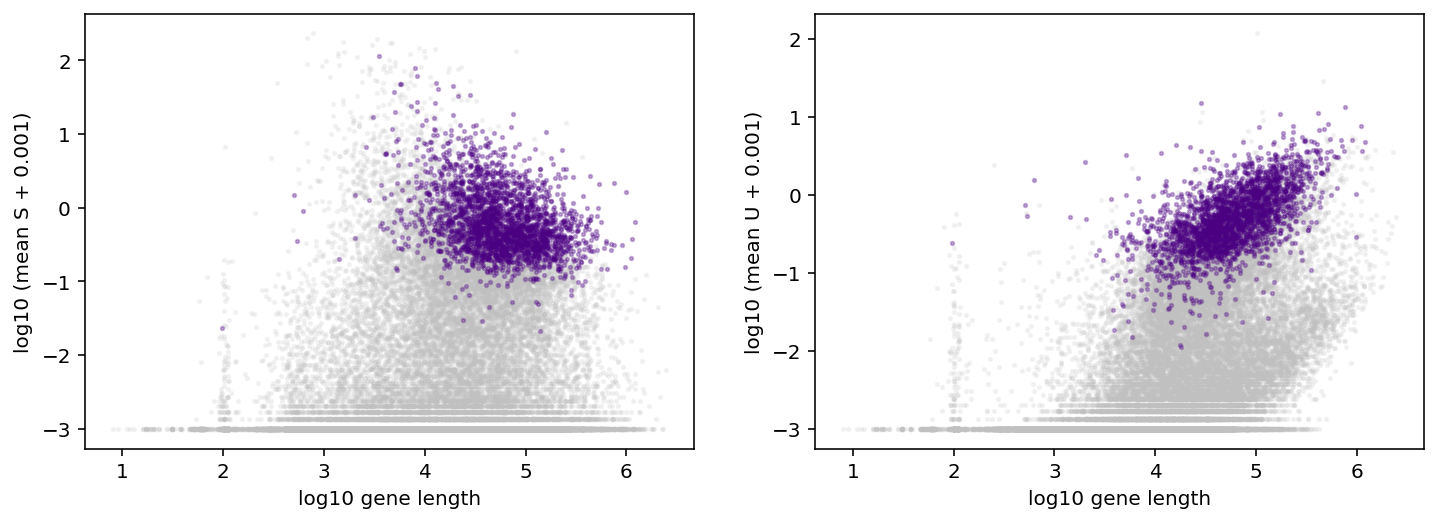

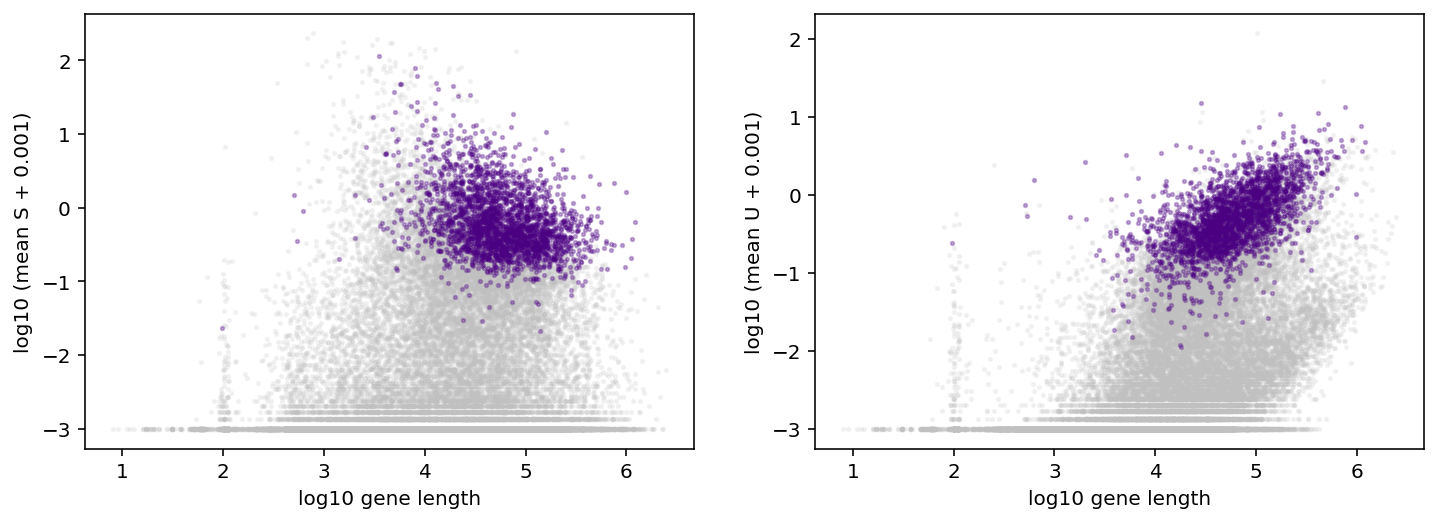

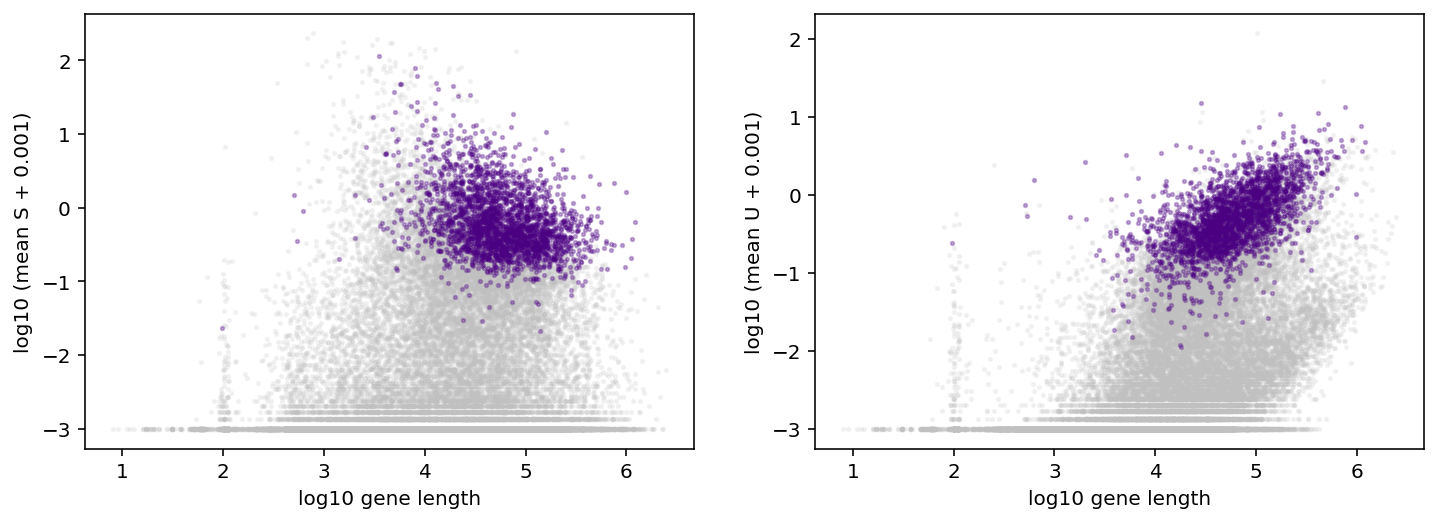

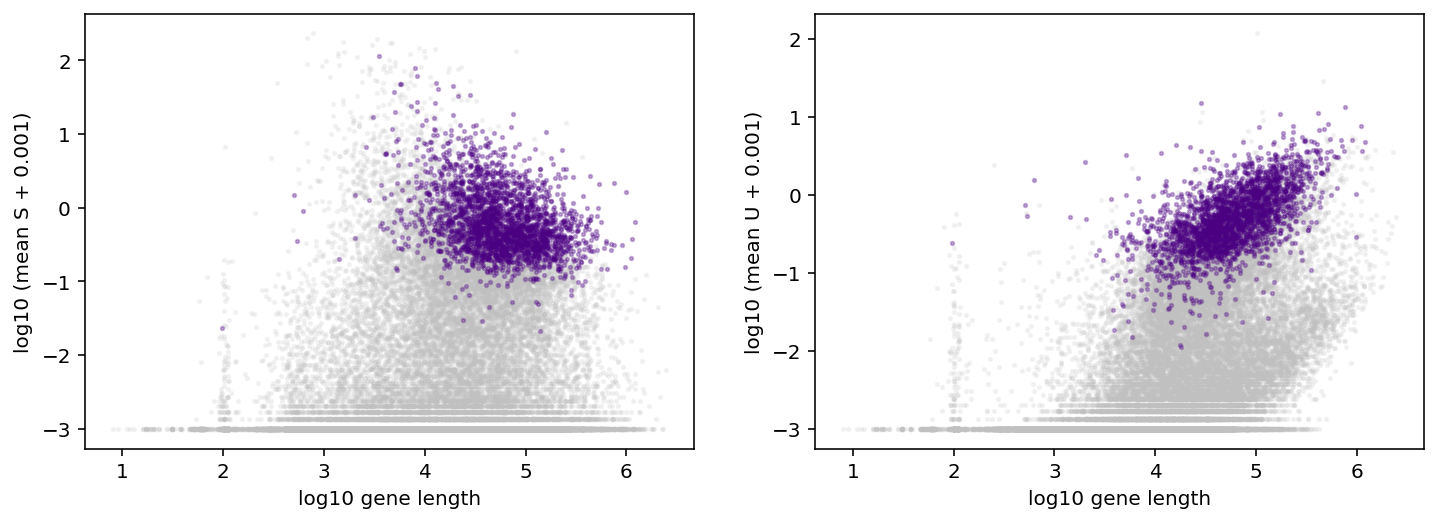

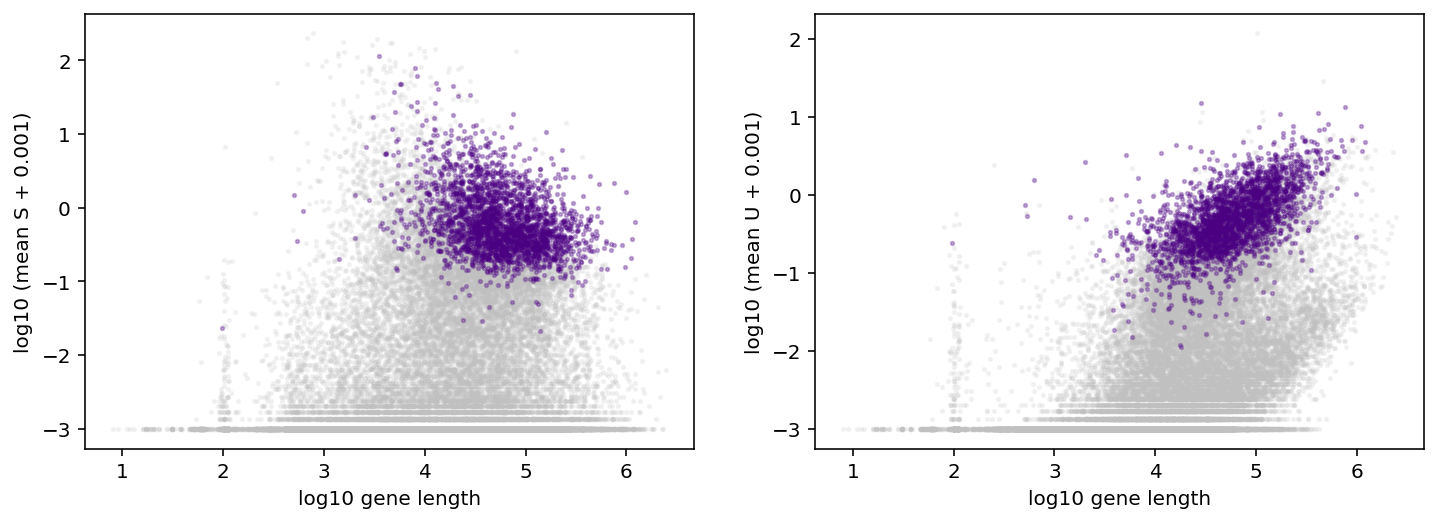

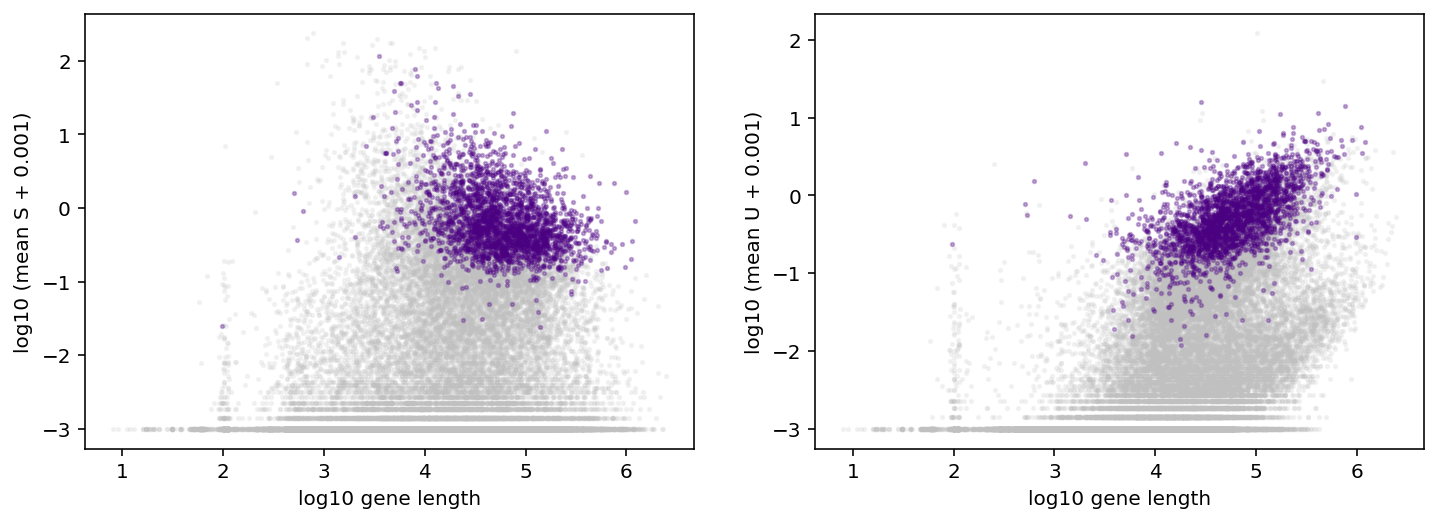

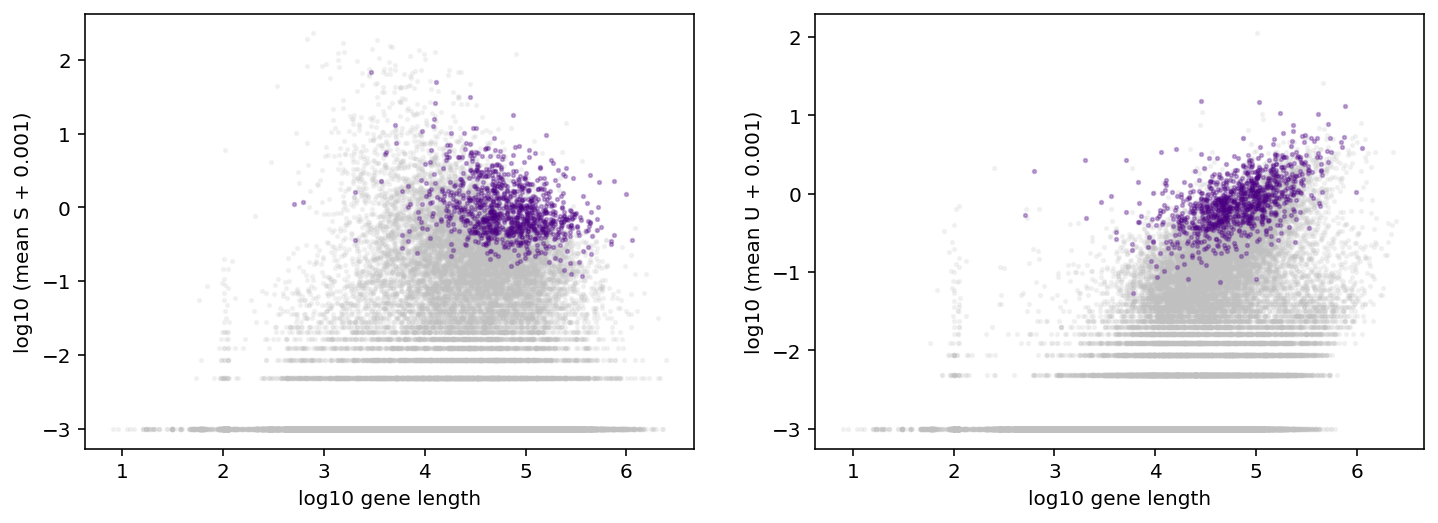

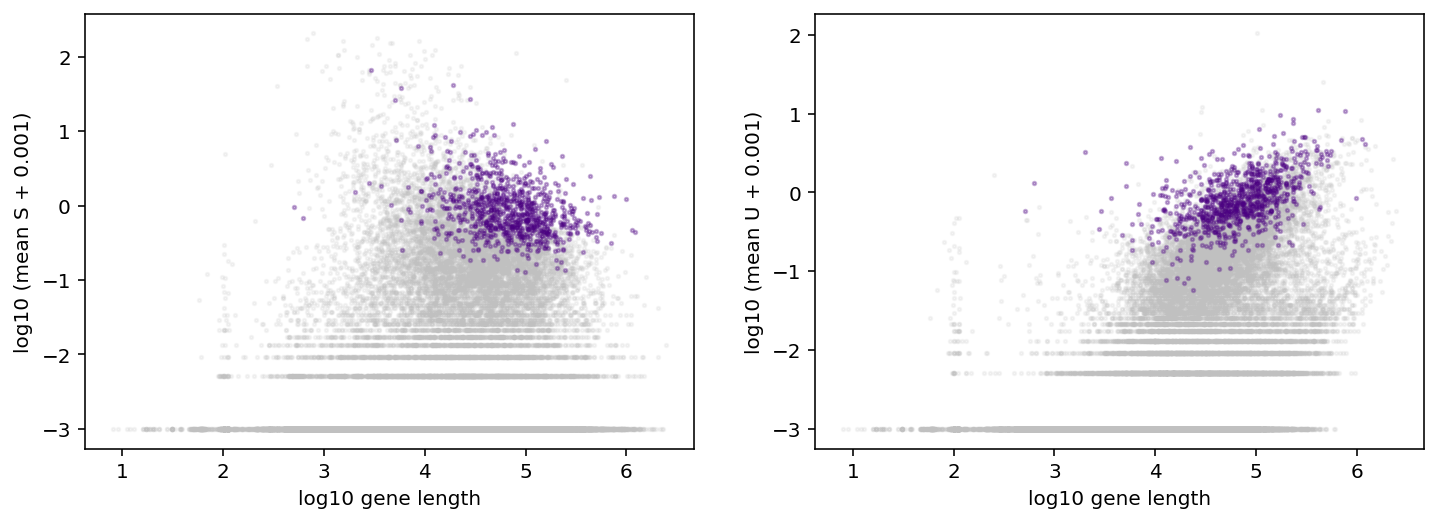

In [21]:
dir_string,dataset_strings = monod.preprocess.construct_batch(loom_filepaths, \
                                             transcriptome_filepath, \
                                             dataset_names, \
                                             attribute_names=attribute_names,\
                                             batch_location='./fits',meta='norman_crispr_MM',batch_id=1,\
                                             datestring='230412', n_genes=2000,\
                                             exp_filter_threshold=None,cf=cf,genes_to_fit=markers)

In [14]:
# dir_string = './fits/gg_230412_025_norman_crispr_test_MM_1'

In [15]:
# dataset_strings = [ dir_string+'/'+item for item in os.listdir(dir_string) if os.path.isdir(os.path.join(dir_string, item)) ]


## **Test Mixture Model Inference**

In [22]:
#Define bounds, from 20220930_normanfit_monod.ipynb
phys_lb = [-2.0, -1.8, -1.8 ] #-1.0, -1.8, -1.8
phys_ub = [4.2, 2.5, 2.5] #4.2, 2.5, 3.5
samp_lb = [-7.157894736842105, -1.25] #-7.5, -2
samp_ub = [-7.157894736842105, -1.25] #-5.5, 0
# gridsize = [5,6]
gridsize = [1,1]


INFO:root:Directory ./fits/gg_230412_025_norman_crispr_MM_1/norman_allcrispr_NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230412_025_norman_crispr_MM_1/norman_allcrispr_NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: norman_allcrispr_NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_norman_crispr_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230412_025_norman_crispr_MM_1/norman_allcrispr_NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_230412_025_norman_crispr_MM_1/norman_allcrispr_NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:57<00:00, 57.95s/it]


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230412_025_norman_crispr_MM_1/norman_allcrispr_NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0/Bursty_Poisson_1x1/analysis_figures created.
INFO:root:Runtime: 64.1 seconds.
INFO:root:Directory ./fits/gg_230412_025_norman_crispr_MM_1/norman_allcrispr_DUSP9_MAPK1__DUSP9_MAPK1/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230412_025_norman_crispr_MM_1/norman_allcrispr_DUSP9_MAPK1__DUSP9_MAPK1/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: norman_allcrispr_DUSP9_MAPK1__DUSP9_MAPK1
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_norman_crispr_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230412_025_norman_crispr_MM_1/norman_allcrispr_DUSP9_MAPK1__DUSP9_MAPK1/diagnostic_figures created.
INFO:root:Search data 

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:47<00:00, 47.44s/it]


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230412_025_norman_crispr_MM_1/norman_allcrispr_DUSP9_MAPK1__DUSP9_MAPK1/Bursty_Poisson_1x1/analysis_figures created.
INFO:root:Runtime: 53.7 seconds.
INFO:root:Directory ./fits/gg_230412_025_norman_crispr_MM_1/norman_allcrispr_CBL_CNN1__CBL_CNN1/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230412_025_norman_crispr_MM_1/norman_allcrispr_CBL_CNN1__CBL_CNN1/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: norman_allcrispr_CBL_CNN1__CBL_CNN1
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_norman_crispr_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230412_025_norman_crispr_MM_1/norman_allcrispr_CBL_CNN1__CBL_CNN1/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_230412_025_norma

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:49<00:00, 49.05s/it]


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230412_025_norman_crispr_MM_1/norman_allcrispr_CBL_CNN1__CBL_CNN1/Bursty_Poisson_1x1/analysis_figures created.
INFO:root:Runtime: 55.4 seconds.


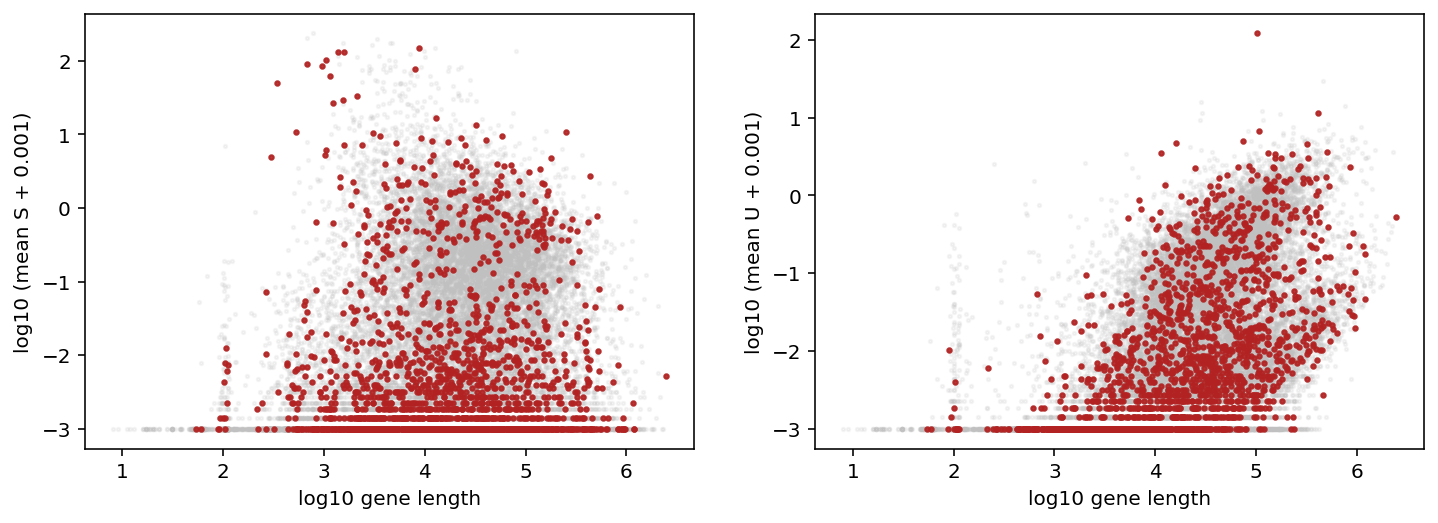

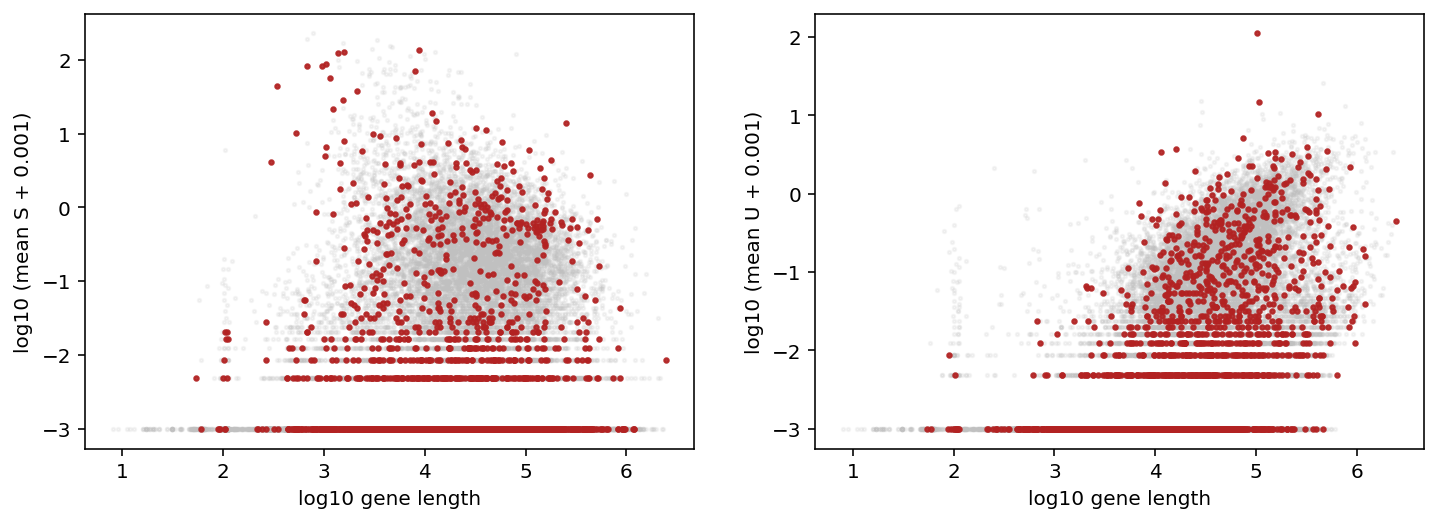

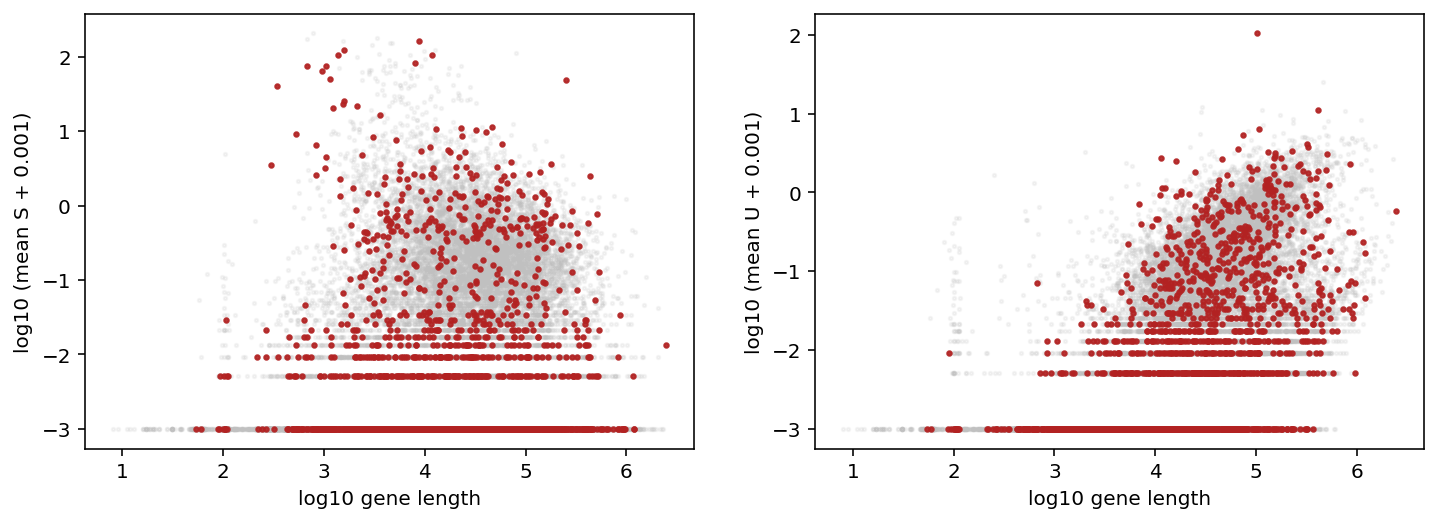

In [23]:
#Run Monod as control on separate groups
result_strings = []
#for i in range(1,2): #n_datasets
for i in range(5,len(dataset_names)):

    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')

    inference_parameters = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,use_lengths = True,
                gradient_params = {'max_iterations':20,'init_pattern':'moments','num_restarts':1})

    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, dataset_attr_names=attribute_names,cf=cf[i])

    full_result_string = inference_parameters.fit_all_grid_points(30,search_data)

    result_strings.append(full_result_string)

In [24]:
sr = [monod.analysis.load_search_results(i) for i in result_strings]
sr

INFO:root:Grid scan results loaded from ./fits/gg_230412_025_norman_crispr_MM_1/norman_allcrispr_NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0/Bursty_Poisson_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230412_025_norman_crispr_MM_1/norman_allcrispr_DUSP9_MAPK1__DUSP9_MAPK1/Bursty_Poisson_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230412_025_norman_crispr_MM_1/norman_allcrispr_CBL_CNN1__CBL_CNN1/Bursty_Poisson_1x1/grid_scan_results.res.


In [ ]:
all_assigns_num = [assigns_dict[i] for i in all_assigns[2]]

INFO:root:Beginning data extraction.
INFO:root:Dataset: norman_allcrispr_NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0_DUSP9_MAPK1__DUSP9_MAPK1_CBL_CNN1__CBL_CNN1_k5
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_norman_crispr_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230412_025_norman_crispr_MM_1/norman_allcrispr_NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0_DUSP9_MAPK1__DUSP9_MAPK1_CBL_CNN1__CBL_CNN1_k5/diagnostic_figures already exists.
INFO:root:Search data stored to ./fits/gg_230412_025_norman_crispr_MM_1/norman_allcrispr_NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0_DUSP9_MAPK1__DUSP9_MAPK1_CBL_CNN1__CBL_CNN1_k5/raw.sd.


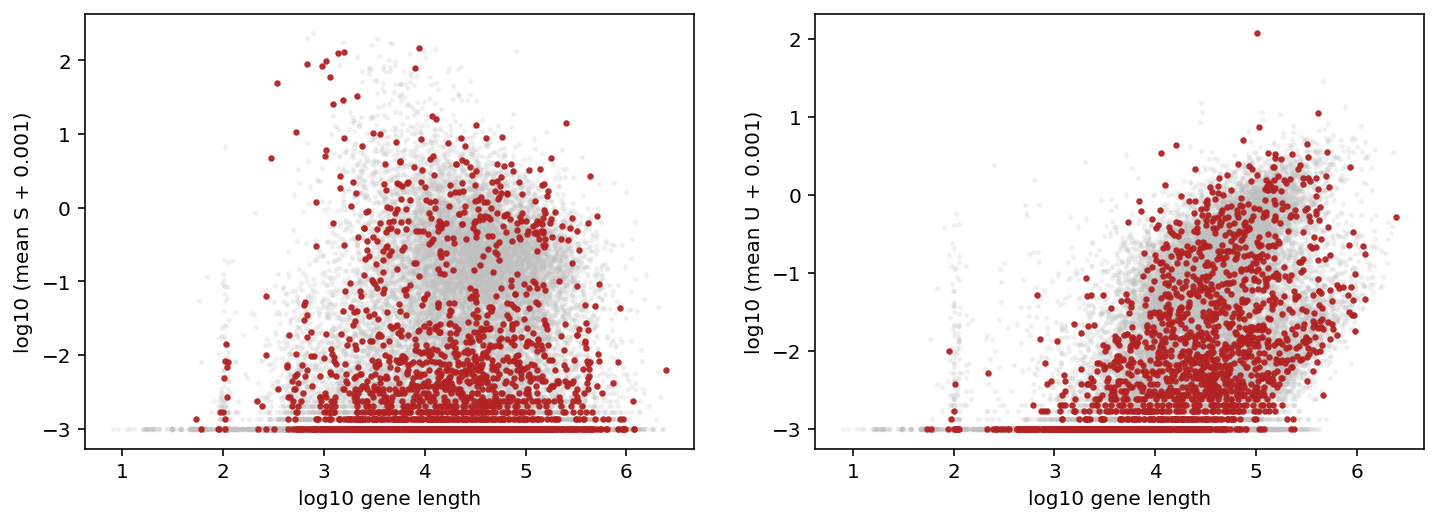

In [41]:
#Print init by k-means
which = 4
search_data = monod.extract_data.extract_data(loom_filepaths[which], transcriptome_filepath, dataset_names[which],
            dataset_strings[which], dir_string, dataset_attr_names=attribute_names,cf=cf[which])

S = search_data.layers[1,:,:]
S_t = S.T
tots = np.sum(S_t,axis=1)
divids = (1e4/tots)[:,None]
S_t = S_t*divids
S_t = np.log1p(S_t)

kmeans = KMeans(n_clusters=ks[which], random_state=0).fit(S_t)
labs = kmeans.labels_


    
    

Text(0.5, 1.0, 'K-Means Init: norman_allcrispr_NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0_DUSP9_MAPK1__DUSP9_MAPK1_CBL_CNN1__CBL_CNN1_k3')

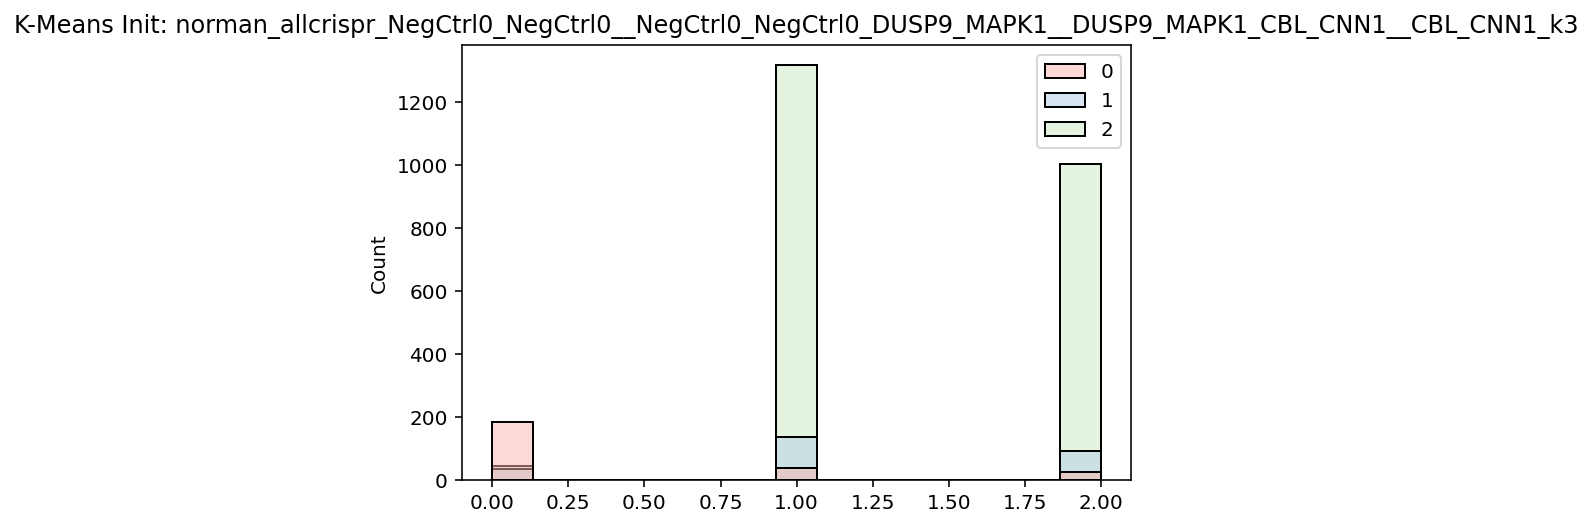

In [34]:
labels = labs
plt.figure()
sns.histplot(x=labels,hue=pd.Categorical(all_assigns_num), kde=False,palette='Pastel1')
plt.title('K-Means Init: '+dataset_names[which])


In [44]:
#Get top 2k var genes to use, from loom S
ds = lp.connect('/home/tchari/counts/allen_bivi/loom/B08_processed_hv.loom')
ds

In [47]:
cell_types = ds.ca['Cell Type']
barcodes = ds.ca['barcode']


In [52]:
counts = ds.layers['counts'][:,:]

In [55]:
ds.close()

In [75]:
counts.shape

(4000, 6418)

In [99]:
spliced = counts[2000:-1,:].T

In [100]:
unspliced = counts[0:2000,:].T

In [101]:
np.unique(cell_types)

array(['Astro', 'Endo', 'L2/3 IT', 'L5 ET', 'L5 IT', 'L5/6 NP', 'L6 CT',
       'L6 IT', 'L6 IT Car3', 'L6b', 'Lamp5', 'Macrophage', 'OPC',
       'Oligo', 'Pvalb', 'SMC', 'Sncg', 'Sst', 'VLMC', 'Vip'],
      dtype=object)

In [102]:
inds = pd.Categorical(cell_types).isin(['L2/3 IT','L5 IT','L6 IT'])
sub = spliced[inds,:]
sub_u = unspliced[inds,:]
sub.shape

(3707, 1999)

In [103]:
name_dict = dict(zip(['L2/3 IT','L5 IT','L6 IT'],[0,1,2]))

trues = [name_dict[i] for i in cell_types[inds]]

In [104]:
pd.Categorical(cell_types).value_counts()

Astro           49
Endo            21
L2/3 IT        823
L5 ET            9
L5 IT         2395
L5/6 NP        251
L6 CT         1333
L6 IT          489
L6 IT Car3       3
L6b             66
Lamp5          192
Macrophage      17
OPC             17
Oligo           82
Pvalb          114
SMC              1
Sncg            45
Sst            271
VLMC             7
Vip            233
dtype: int64

In [111]:
tots = np.sum(sub_u,axis=1)
divids = (1e4/tots)[:,None]
sub_t = sub_u*divids
sub_t = np.log1p(sub_t)


Text(0.5, 1.0, 'K-Means Init: ')

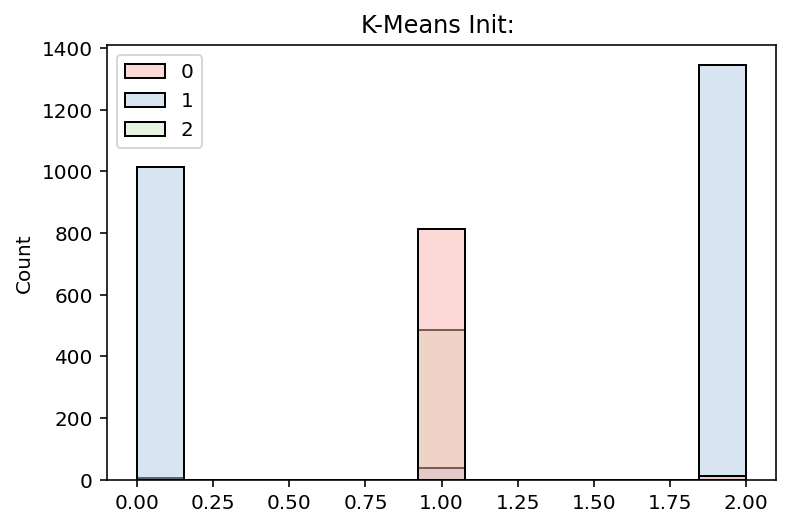

In [108]:

kmeans = KMeans(n_clusters=3, random_state=0).fit(sub_t)
labs = kmeans.labels_


labels = labs
plt.figure()
sns.histplot(x=labels,hue=pd.Categorical(trues), kde=False,palette='Pastel1')
plt.title('K-Means Init: ')


Text(0.5, 1.0, 'K-Means Init: ')

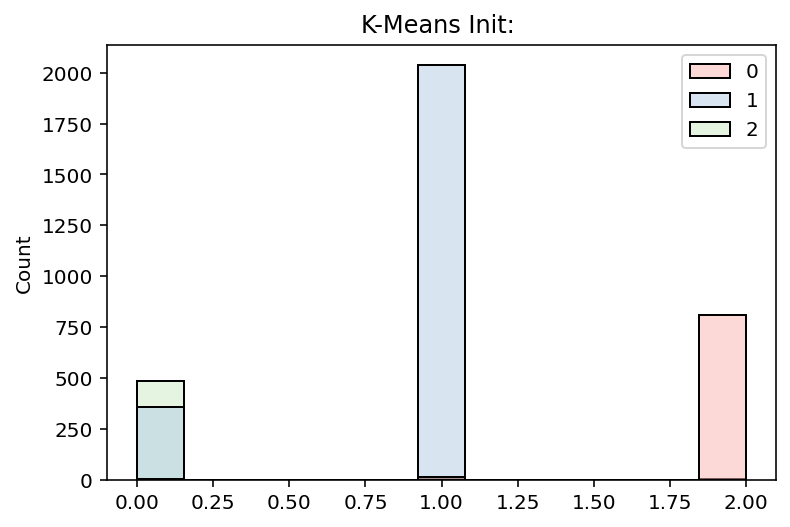

In [112]:
#unspliced

kmeans = KMeans(n_clusters=3, random_state=0).fit(sub_t)
labs = kmeans.labels_


labels = labs
plt.figure()
sns.histplot(x=labels,hue=pd.Categorical(trues), kde=False,palette='Pastel1')
plt.title('K-Means Init: ')


In [ ]:

S = search_data.layers[1,:,:]
S_t = S.T
tots = np.sum(S_t,axis=1)
divids = (1e4/tots)[:,None]
S_t = S_t*divids
S_t = np.log1p(S_t)

kmeans = KMeans(n_clusters=ks[which], random_state=0).fit(S_t)
labs = kmeans.labels_


labels = labs
plt.figure()
sns.histplot(x=labels,hue=pd.Categorical(all_assigns_num), kde=False,palette='Pastel1')
plt.title('K-Means Init: '+dataset_names[which])



[Text(1, 0.5, '452'),
 Text(1, 1.5, '1047'),
 Text(1, 2.5, '1431'),
 Text(1, 3.5, '1711'),
 Text(1, 4.5, '2233'),
 Text(1, 5.5, '477'),
 Text(1, 6.5, '1493'),
 Text(1, 7.5, '2041'),
 Text(1, 8.5, '95'),
 Text(1, 9.5, '1739'),
 Text(1, 10.5, '596'),
 Text(1, 11.5, '1354'),
 Text(1, 12.5, '1458'),
 Text(1, 13.5, '123'),
 Text(1, 14.5, '230'),
 Text(1, 15.5, '1721'),
 Text(1, 16.5, '417'),
 Text(1, 17.5, '1499'),
 Text(1, 18.5, '2581'),
 Text(1, 19.5, '1534'),
 Text(1, 20.5, '1587'),
 Text(1, 21.5, '1260'),
 Text(1, 22.5, '1627'),
 Text(1, 23.5, '1725'),
 Text(1, 24.5, '1569'),
 Text(1, 25.5, '1648'),
 Text(1, 26.5, '1358'),
 Text(1, 27.5, '1452'),
 Text(1, 28.5, '1455'),
 Text(1, 29.5, '1462'),
 Text(1, 30.5, '1590'),
 Text(1, 31.5, '1134'),
 Text(1, 32.5, '1195'),
 Text(1, 33.5, '547'),
 Text(1, 34.5, '1744'),
 Text(1, 35.5, '1063'),
 Text(1, 36.5, '1720'),
 Text(1, 37.5, '1538'),
 Text(1, 38.5, '2093'),
 Text(1, 39.5, '2099'),
 Text(1, 40.5, '2444'),
 Text(1, 41.5, '301'),
 Text(1, 42.

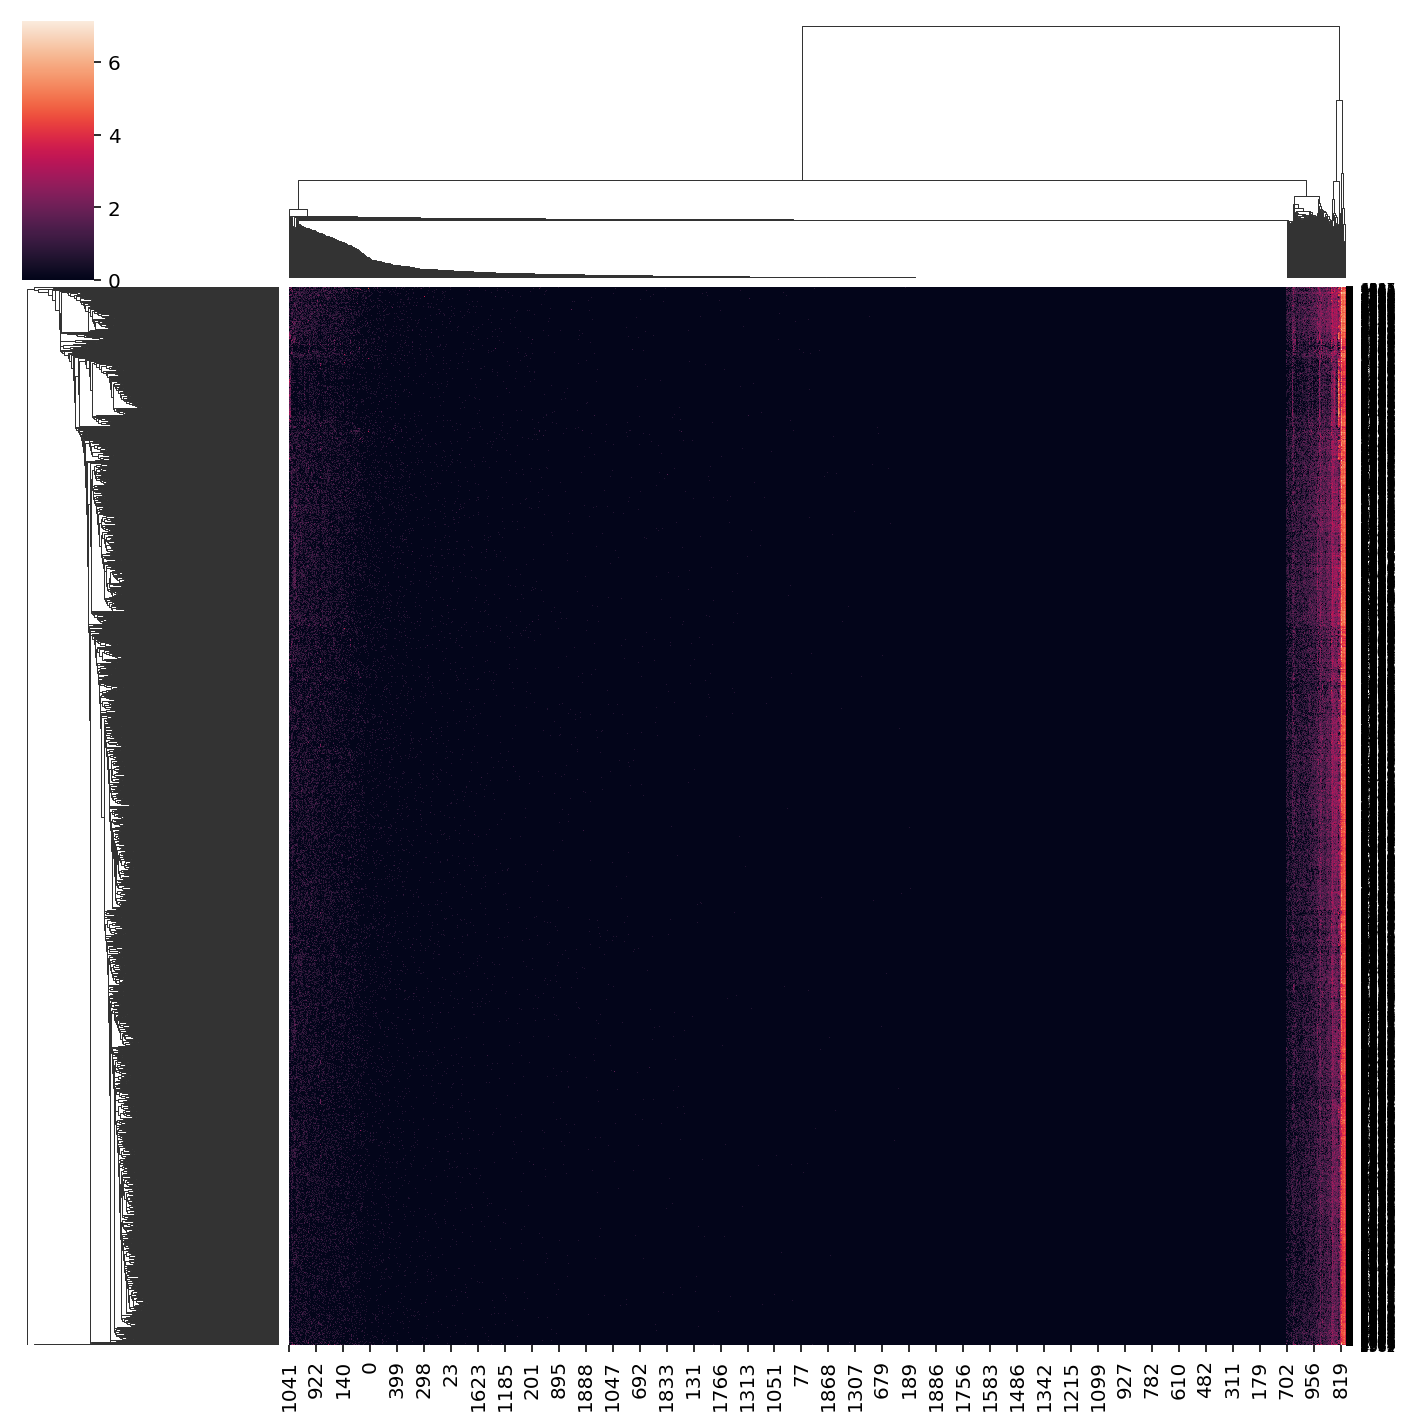

In [43]:
#How separated are clusters by 'DE genes,', Shows N and M
g = sns.clustermap(np.log1p(S.T),yticklabels=True)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 7)



In [25]:
epochs=10

INFO:root:Directory ./fits/gg_230412_025_norman_crispr_MM_1/norman_allcrispr_NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0_DUSP9_MAPK1__DUSP9_MAPK1_CBL_CNN1__CBL_CNN1_k1/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230412_025_norman_crispr_MM_1/norman_allcrispr_NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0_DUSP9_MAPK1__DUSP9_MAPK1_CBL_CNN1__CBL_CNN1_k1/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: norman_allcrispr_NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0_DUSP9_MAPK1__DUSP9_MAPK1_CBL_CNN1__CBL_CNN1_k1
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_norman_crispr_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230412_025_norman_crispr_MM_1/norman_allcrispr_NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0_DUSP9_MAPK1__DUSP9_MAPK1_CBL_CNN1__CBL_CNN1_k1/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_230412_025_norman_crispr_MM_

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:27<00:00, 327.90s/it]


INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:23<00:00, 323.84s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -4109657.672878473

INFO:root:EM Epoch 2/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:23<00:00, 323.10s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -4109657.672878473

INFO:root:EM Epoch 3/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:22<00:00, 322.12s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -4109657.672878473

INFO:root:EM Epoch 4/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:21<00:00, 321.99s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -4109657.672878473

INFO:root:EM Epoch 5/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:22<00:00, 322.88s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -4109657.672878473

INFO:root:EM Epoch 6/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:22<00:00, 322.45s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -4109657.672878473

INFO:root:EM Epoch 7/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:22<00:00, 322.33s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -4109657.672878473

INFO:root:EM Epoch 8/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:22<00:00, 322.87s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -4109657.672878473

INFO:root:EM Epoch 9/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:22<00:00, 322.53s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -4109657.672878473

INFO:root:EM Epoch 10/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:23<00:00, 323.33s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -4109657.672878473

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230412_025_norman_crispr_MM_1/norman_allcrispr_NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0_DUSP9_MAPK1__DUSP9_MAPK1_CBL_CNN1__CBL_CNN1_k2/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230412_025_norman_crispr_MM_1/norman_allcrispr_NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0_DUSP9_MAPK1__DUSP9_MAPK1_CBL_CNN1__CBL_CNN1_k2/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: norman_allcrispr_NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0_DUSP9_MAPK1__DUSP9_MAPK1_CBL_CNN1__CBL_CNN1_k2
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_norman_crispr_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230412_025_norman_crispr_MM_1/norman_allcrispr_NegCtrl0_NegCtrl0__NegCtrl0_NegCtr

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [05:25<00:00, 162.75s/it]


INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:23<00:00, 323.97s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.48675035e-10 1.00000000e+00]
Q Function:  -4227939.872149277

INFO:root:EM Epoch 2/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:22<00:00, 322.81s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.48675035e-10 1.00000000e+00]
Q Function:  -3876775.7966879867

INFO:root:EM Epoch 3/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:22<00:00, 322.69s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.48675035e-10 1.00000000e+00]
Q Function:  -3876775.7966879867

INFO:root:EM Epoch 4/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:32<00:00, 332.79s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.48675035e-10 1.00000000e+00]
Q Function:  -3876775.7966879867

INFO:root:EM Epoch 5/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:32<00:00, 332.95s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.48675035e-10 1.00000000e+00]
Q Function:  -3876775.7966879867

INFO:root:EM Epoch 6/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:21<00:00, 321.76s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.48675035e-10 1.00000000e+00]
Q Function:  -3876775.7966879867

INFO:root:EM Epoch 7/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:22<00:00, 322.50s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.48675035e-10 1.00000000e+00]
Q Function:  -3876775.7966879867

INFO:root:EM Epoch 8/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:22<00:00, 322.11s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.48675035e-10 1.00000000e+00]
Q Function:  -3876775.7966879867

INFO:root:EM Epoch 9/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:22<00:00, 322.02s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.48675035e-10 1.00000000e+00]
Q Function:  -3876775.7966879867

INFO:root:EM Epoch 10/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:25<00:00, 325.18s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.48675035e-10 1.00000000e+00]
Q Function:  -3876775.7966879867

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230412_025_norman_crispr_MM_1/norman_allcrispr_NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0_DUSP9_MAPK1__DUSP9_MAPK1_CBL_CNN1__CBL_CNN1_k3/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230412_025_norman_crispr_MM_1/norman_allcrispr_NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0_DUSP9_MAPK1__DUSP9_MAPK1_CBL_CNN1__CBL_CNN1_k3/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: norman_allcrispr_NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0_DUSP9_MAPK1__DUSP9_MAPK1_CBL_CNN1__CBL_CNN1_k3
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_norman_crispr_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230412_025_norman_crispr_MM_1/norman_allcrispr_NegCtr

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [06:18<00:00, 126.19s/it]


INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [06:02<00:00, 120.74s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.01849525 0.97940373 0.00210101]
Q Function:  -4181254.9974438236

INFO:root:EM Epoch 2/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:21<00:00, 321.40s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.48675035e-10 9.99999999e-01 3.48675035e-10]
Q Function:  -4141666.662982948

INFO:root:EM Epoch 3/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:35<00:00, 335.13s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.48675035e-10 9.99999999e-01 3.48675035e-10]
Q Function:  -3969536.4664290785

INFO:root:EM Epoch 4/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:42<00:00, 342.64s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.48675035e-10 9.99999999e-01 3.48675035e-10]
Q Function:  -3969536.4664290785

INFO:root:EM Epoch 5/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:25<00:00, 325.26s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.48675035e-10 9.99999999e-01 3.48675035e-10]
Q Function:  -3969536.4664290785

INFO:root:EM Epoch 6/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:22<00:00, 322.90s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.48675035e-10 9.99999999e-01 3.48675035e-10]
Q Function:  -3969536.4664290785

INFO:root:EM Epoch 7/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:23<00:00, 323.52s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.48675035e-10 9.99999999e-01 3.48675035e-10]
Q Function:  -3969536.4664290785

INFO:root:EM Epoch 8/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:22<00:00, 322.25s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.48675035e-10 9.99999999e-01 3.48675035e-10]
Q Function:  -3969536.4664290785

INFO:root:EM Epoch 9/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:22<00:00, 322.68s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.48675035e-10 9.99999999e-01 3.48675035e-10]
Q Function:  -3969536.4664290785

INFO:root:EM Epoch 10/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:22<00:00, 322.46s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.48675035e-10 9.99999999e-01 3.48675035e-10]
Q Function:  -3969536.4664290785

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230412_025_norman_crispr_MM_1/norman_allcrispr_NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0_DUSP9_MAPK1__DUSP9_MAPK1_CBL_CNN1__CBL_CNN1_k4/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230412_025_norman_crispr_MM_1/norman_allcrispr_NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0_DUSP9_MAPK1__DUSP9_MAPK1_CBL_CNN1__CBL_CNN1_k4/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: norman_allcrispr_NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0_DUSP9_MAPK1__DUSP9_MAPK1_CBL_CNN1__CBL_CNN1_k4
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_norman_crispr_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230412_025_norman_crispr_MM_1/norman_a

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [05:57<00:00, 89.36s/it]


INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [06:26<00:00, 193.31s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.15843603e-08 3.48675383e-04 3.48675034e-10 9.99651233e-01]
Q Function:  -4147363.1385581857

INFO:root:EM Epoch 2/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:38<00:00, 338.23s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.48675034e-10 3.48675034e-10 3.48675034e-10 9.99999999e-01]
Q Function:  -3781413.682715452

INFO:root:EM Epoch 3/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [06:11<00:00, 371.33s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.48675034e-10 3.48675034e-10 3.48675034e-10 9.99999999e-01]
Q Function:  -3748952.144836204

INFO:root:EM Epoch 4/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:39<00:00, 339.98s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.48675034e-10 3.48675034e-10 3.48675034e-10 9.99999999e-01]
Q Function:  -3748952.144836204

INFO:root:EM Epoch 5/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:38<00:00, 338.76s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.48675034e-10 3.48675034e-10 3.48675034e-10 9.99999999e-01]
Q Function:  -3748952.144836204

INFO:root:EM Epoch 6/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:32<00:00, 332.16s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.48675034e-10 3.48675034e-10 3.48675034e-10 9.99999999e-01]
Q Function:  -3748952.144836204

INFO:root:EM Epoch 7/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:47<00:00, 347.62s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.48675034e-10 3.48675034e-10 3.48675034e-10 9.99999999e-01]
Q Function:  -3748952.144836204

INFO:root:EM Epoch 8/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:46<00:00, 346.40s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.48675034e-10 3.48675034e-10 3.48675034e-10 9.99999999e-01]
Q Function:  -3748952.144836204

INFO:root:EM Epoch 9/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:48<00:00, 348.64s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.48675034e-10 3.48675034e-10 3.48675034e-10 9.99999999e-01]
Q Function:  -3748952.144836204

INFO:root:EM Epoch 10/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:47<00:00, 347.89s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.48675034e-10 3.48675034e-10 3.48675034e-10 9.99999999e-01]
Q Function:  -3748952.144836204

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230412_025_norman_crispr_MM_1/norman_allcrispr_NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0_DUSP9_MAPK1__DUSP9_MAPK1_CBL_CNN1__CBL_CNN1_k5/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230412_025_norman_crispr_MM_1/norman_allcrispr_NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0_DUSP9_MAPK1__DUSP9_MAPK1_CBL_CNN1__CBL_CNN1_k5/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: norman_allcrispr_NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0_DUSP9_MAPK1__DUSP9_MAPK1_CBL_CNN1__CBL_CNN1_k5
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:Gene list extracted from ./fits/gg_230412_025_norman_crispr_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230412_025_norman_crispr

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:57<00:00, 71.54s/it]


INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [06:18<00:00, 94.52s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.91318279e-01 5.85549620e-02 3.48675034e-10 5.47201617e-02
 1.95406597e-01]
Q Function:  -4366199.785586843

INFO:root:EM Epoch 2/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [05:58<00:00, 179.06s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.98953953e-01 3.48675034e-10 3.48675034e-10 3.48675034e-10
 1.04604632e-03]
Q Function:  -3666245.2537881285

INFO:root:EM Epoch 3/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:48<00:00, 348.24s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.99999999e-01 3.48675034e-10 3.48675034e-10 3.48675034e-10
 3.48675034e-10]
Q Function:  -3904376.122628517

INFO:root:EM Epoch 4/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:36<00:00, 336.65s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.99999999e-01 3.48675034e-10 3.48675034e-10 3.48675034e-10
 3.48675034e-10]
Q Function:  -3889966.6853989307

INFO:root:EM Epoch 5/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:42<00:00, 342.89s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.99999999e-01 3.48675034e-10 3.48675034e-10 3.48675034e-10
 3.48675034e-10]
Q Function:  -3889966.6853989307

INFO:root:EM Epoch 6/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:33<00:00, 333.86s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.99999999e-01 3.48675034e-10 3.48675034e-10 3.48675034e-10
 3.48675034e-10]
Q Function:  -3889966.6853989307

INFO:root:EM Epoch 7/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:34<00:00, 334.87s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.99999999e-01 3.48675034e-10 3.48675034e-10 3.48675034e-10
 3.48675034e-10]
Q Function:  -3889966.6853989307

INFO:root:EM Epoch 8/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:42<00:00, 342.05s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.99999999e-01 3.48675034e-10 3.48675034e-10 3.48675034e-10
 3.48675034e-10]
Q Function:  -3889966.6853989307

INFO:root:EM Epoch 9/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:44<00:00, 344.84s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.99999999e-01 3.48675034e-10 3.48675034e-10 3.48675034e-10
 3.48675034e-10]
Q Function:  -3889966.6853989307

INFO:root:Non-parallelized grid scan complete.


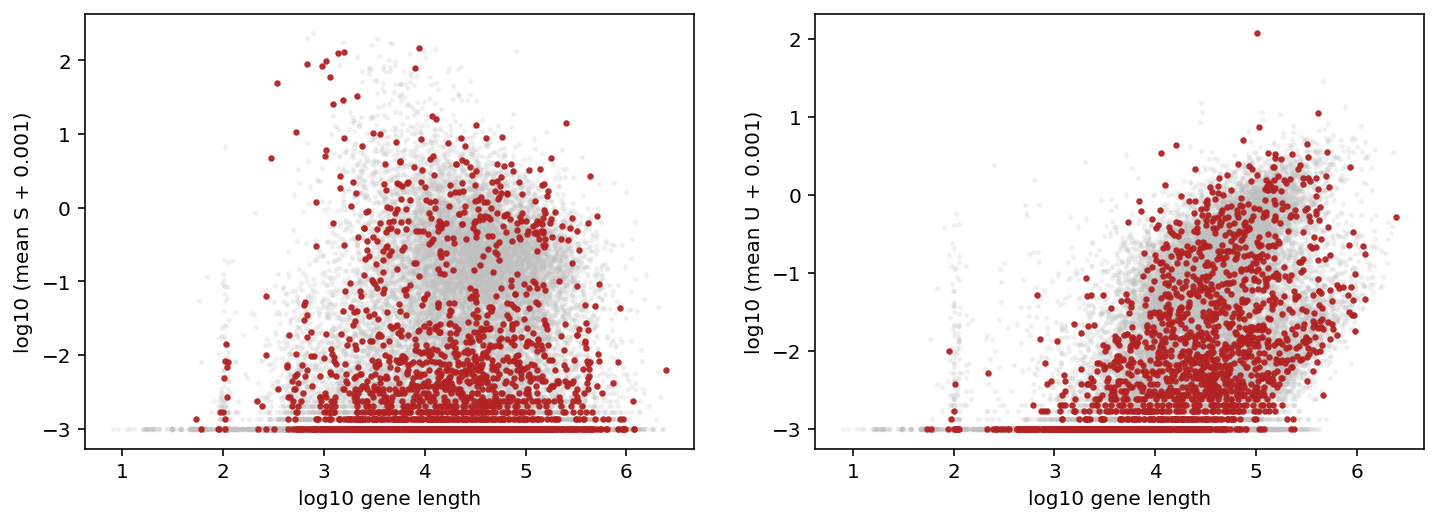

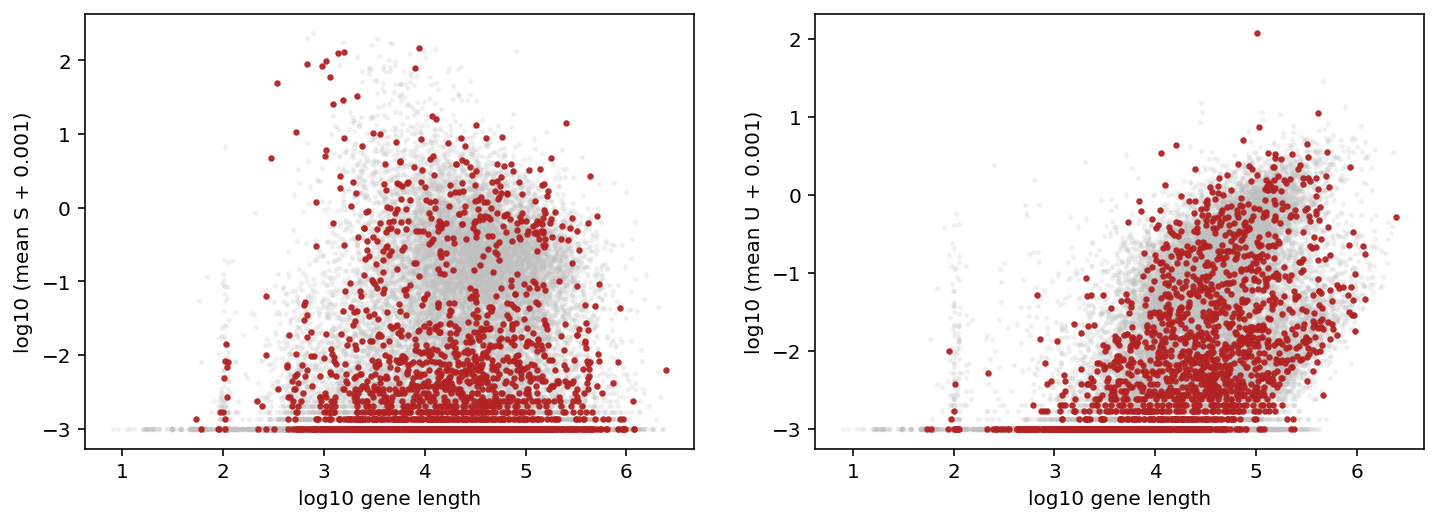

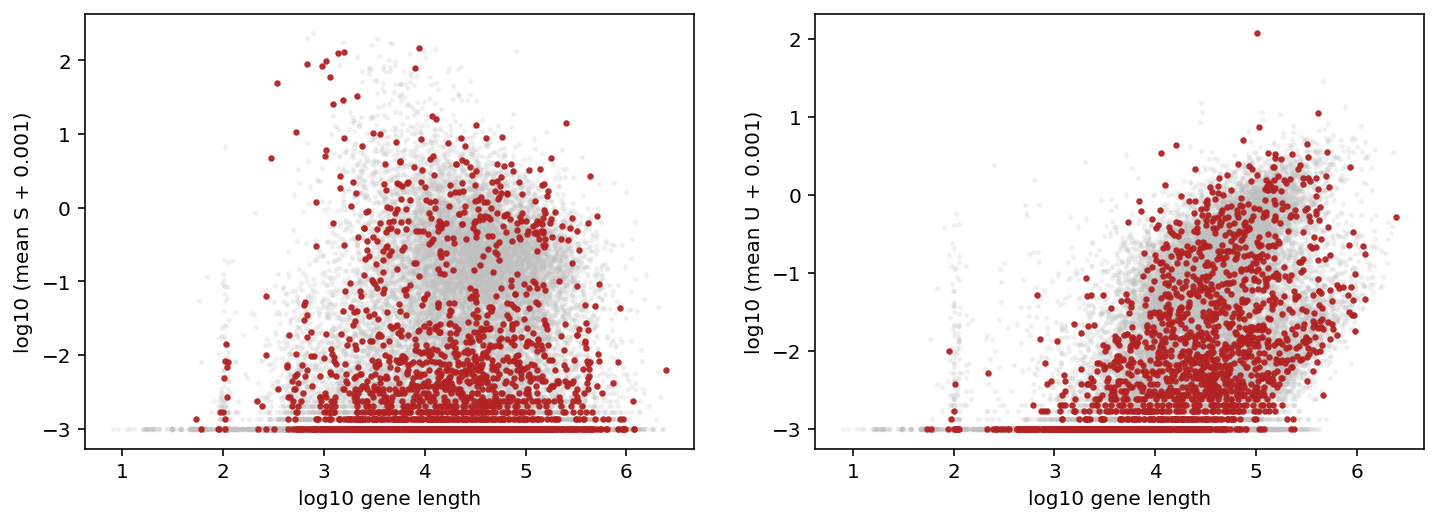

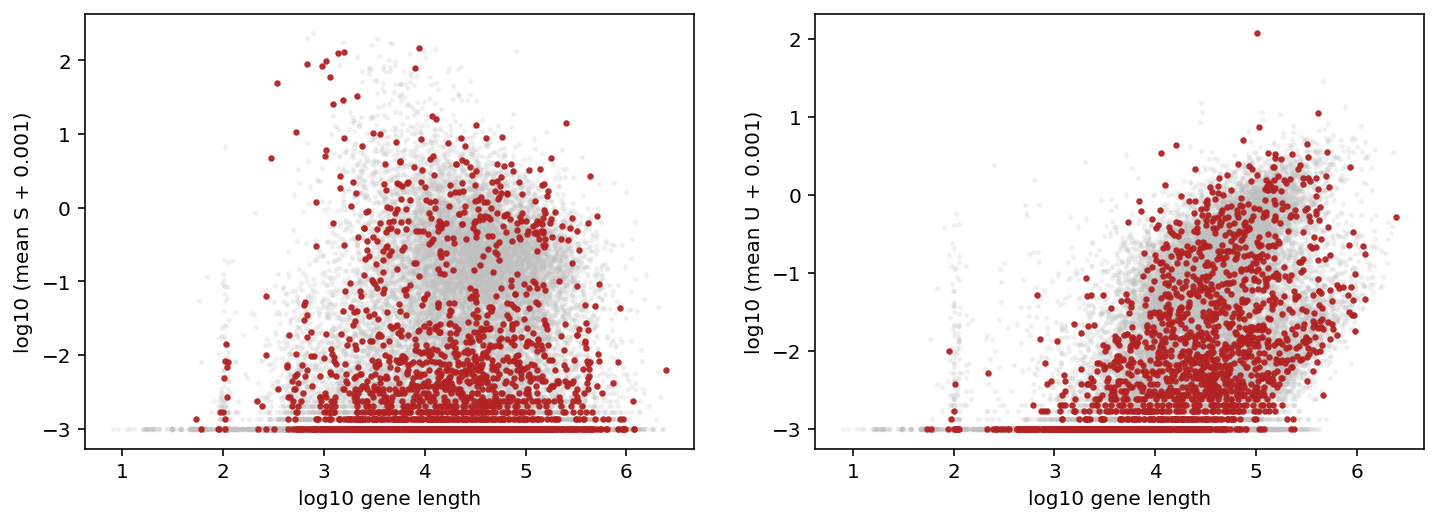

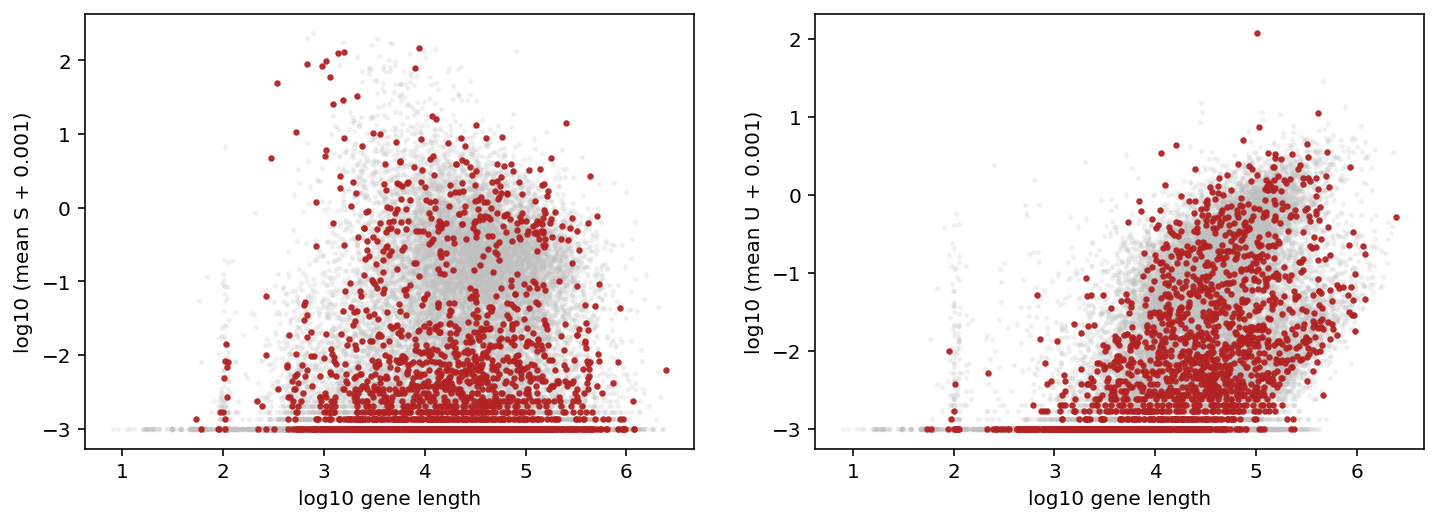

In [26]:
result_strings = []
for i in range(len(dataset_names)-3): #range(len(ks)-2): #n_datasets, running data with all clusters
    
    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')
    
    inference_parameters = monod.mminference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,k=ks[i],epochs=epochs,use_lengths = True,
                gradient_params = {'max_iterations':20,'init_pattern':'moments','num_restarts':1})
    
    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, dataset_attr_names=attribute_names,cf=cf[i])
    
    inference_parameters.fit_all_grid_points(50,search_data)


## **Analysis of Results**

In [103]:
#Plot cluster concordance with true labels and distribution of clusters 
def vis_assign(true,assign,title='',figsize=(18, 5)):
    true_copy = list(true)
    assign_copy = list(assign)
    if np.max(assign) > np.max(true): #FIX
        for a in np.unique(assign):
            if a > np.max(true):
                true_copy += [a]
                assign_copy += [a]
    true_copy = np.array(true_copy)
    assign_copy = np.array(assign_copy)
    
    conmat = confusion_matrix(true_copy, assign_copy)
    val = np.mat(conmat) 
    classnames = list(set(true_copy))
    df_cm = pd.DataFrame(

            val, index=classnames, columns=classnames, 

        )
    
    if np.max(assign) > np.max(true): #FIX
        for a in np.unique(assign):
            if a > np.max(true):
                print(df_cm.shape)
                df_cm.loc[a,a] = df_cm.loc[a,a]-1

    #Plot assignment distributions
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    
    sns.histplot(x=assign,hue=true, kde=False,ax=ax[0],palette='Pastel1')
    ax[0].set_xlabel('MM Assignment')
    ax[0].set_title(title)
    
    #Plot confustion matrix
    heatmap = sns.heatmap(df_cm, annot=True, cmap=sns.color_palette("light:#5A9", as_cmap=True),ax=ax[1])
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0)
    ax[1].set_ylabel('Original label')
    ax[1].set_xlabel('Assigned label')
    
    
    plt.show()

    

In [104]:
#Plot  aics and loss over time for each k iteration

def vis_metrics(results,title,figsize=(18, 5),s=50):
    num_ks = len(results)
    sets = []
    nlls = []
    res = pd.DataFrame()
    aics = pd.DataFrame()
    klds = pd.DataFrame()
    
    aic = []
    fin_k = []
    kls = []
    
    epoch = len(results[0].all_qs)
    epos = list(range(1,epoch+1))*num_ks
    
    for i in range(num_ks):
        
        nlls += list(-1*np.array(results[i].all_qs))
        sets += [i+1]*epoch
        aic += [results[i].aic] #-2*n_cells*clus
        fin_k += [len(np.unique(results[i].assigns))]
        #kls += [np.mean([np.mean(results[i].klds[:,k]) for k in np.unique(results[i].assigns)])]
        
        kls += list(np.median(np.median(np.array(results[i].all_klds)[:,list(np.unique(results[i].assigns))],axis=2),axis=1))
        
        
    
    
    
    res['NLL'] = nlls
    res['KLD'] = kls
    res['epoch'] = epos
    res['setting'] = ['k='+str(j) for j in sets]
    
    aics['AIC'] = aic
    aics['k'] = [str(j) for j in np.array(range(num_ks))+1 ]
    aics['fin_k'] = fin_k
    

    
    
    #Plot klds over time
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    
    sns.lineplot(data=res,x='epoch',y='NLL',hue='setting', 
                    ax=ax[0],palette='Dark2',
                   alpha=0.7,legend=False)
    sns.scatterplot(data=res,x='epoch',y='NLL',hue='setting', 
                    ax=ax[0],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('NLL')
    ax[0].set_title(title)
    
    
    #Plot klds
    sns.lineplot(data=res,x='epoch',y='KLD',hue='setting', 
                    ax=ax[1],palette='Dark2',
                   alpha=0.7,legend=False)
    sns.scatterplot(data=res,x='epoch',y='KLD',hue='setting', 
                    ax=ax[1],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('KLD')

    
    
    #Plot aics
    sns.scatterplot(data=aics,x='fin_k',y='AIC',hue='k', ax=ax[2],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[2].set_xlabel('Final k')
    ax[2].set_ylabel('-AIC')
    ax[2].legend(
          title='k')
    
    
 
    plt.show()
    
    
    


In [105]:
#Mixture Model results
import pickle 
results = [i+'/Bursty_Poisson_1x1/grid_point_0.gp' for i in dataset_strings[:-3]]
grid_point_results = []
for r in results:
    with open(r, "rb") as ipfs:
        grid_point_results += [pickle.load(ipfs)]

    

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


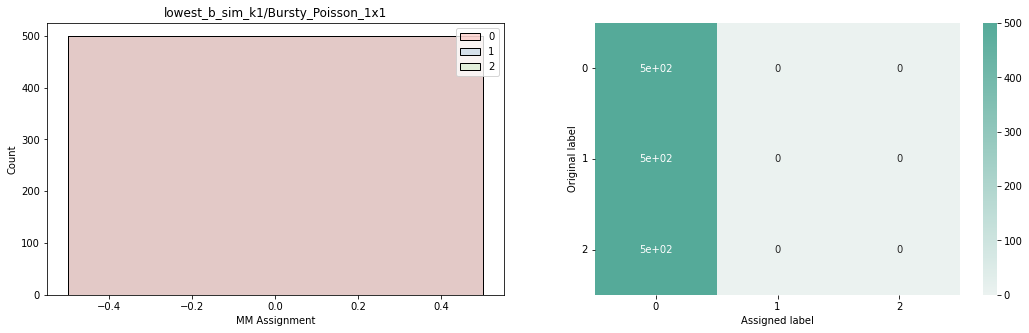

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


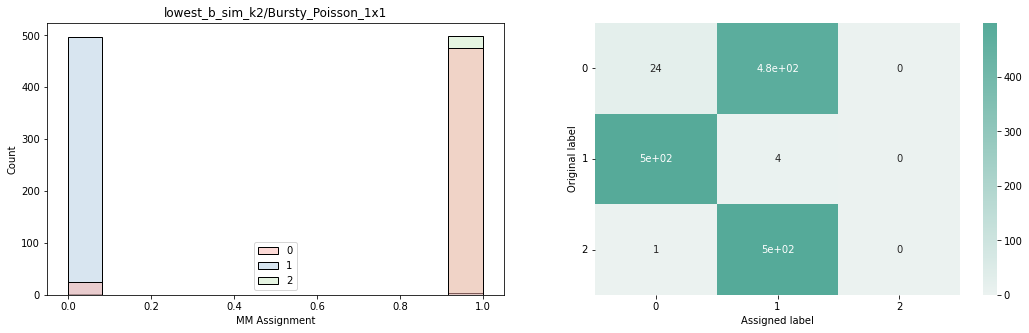

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


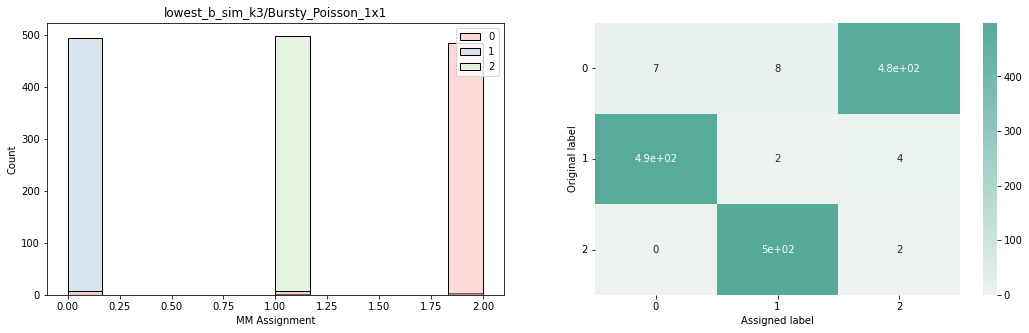

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


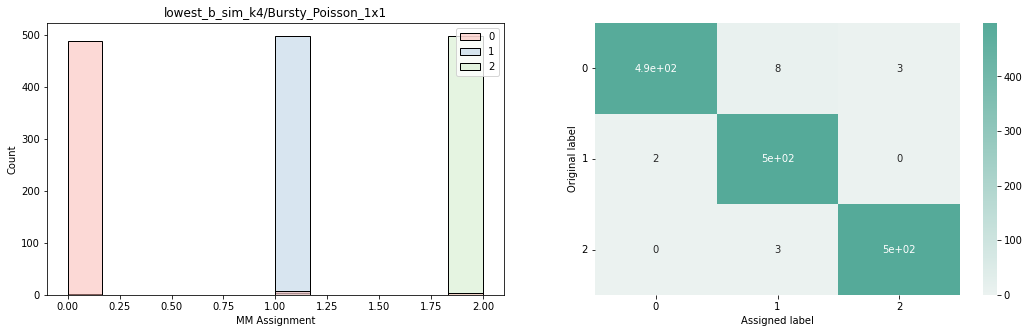

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(4, 4)


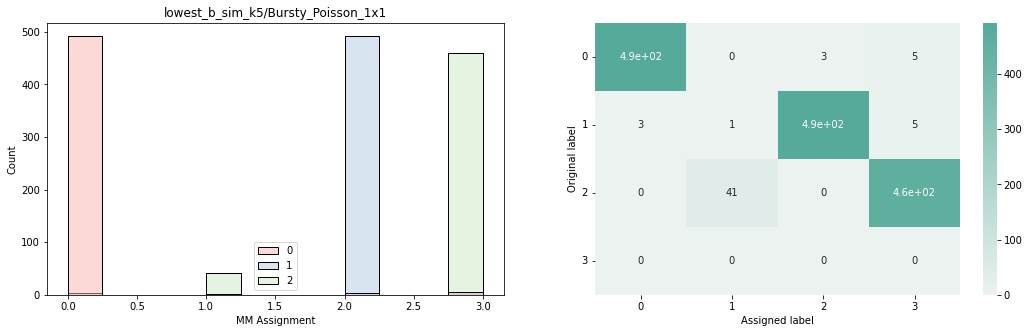

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


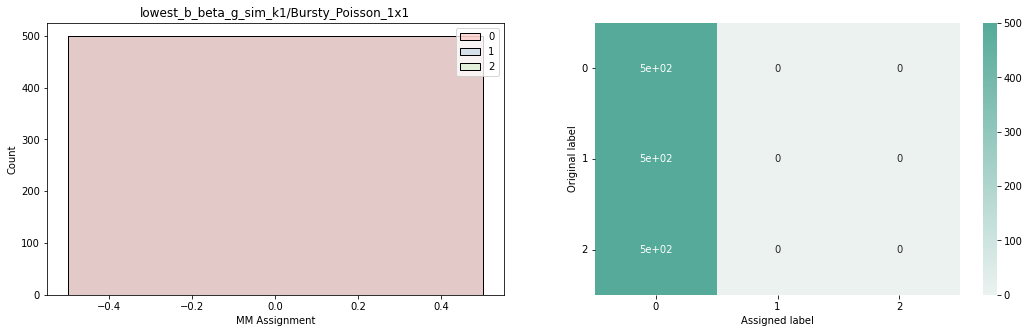

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


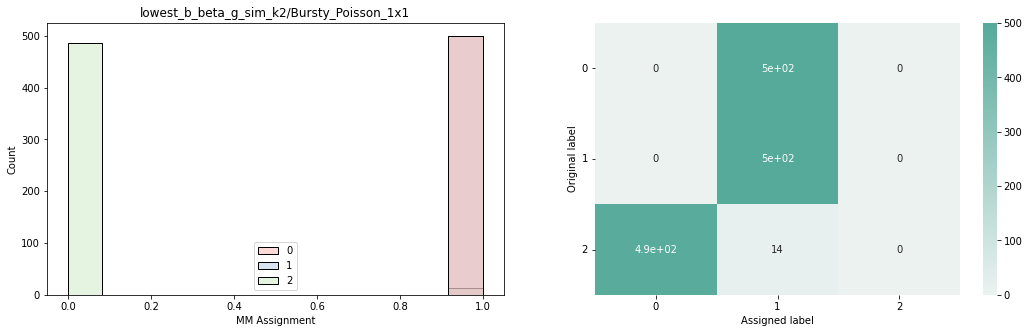

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


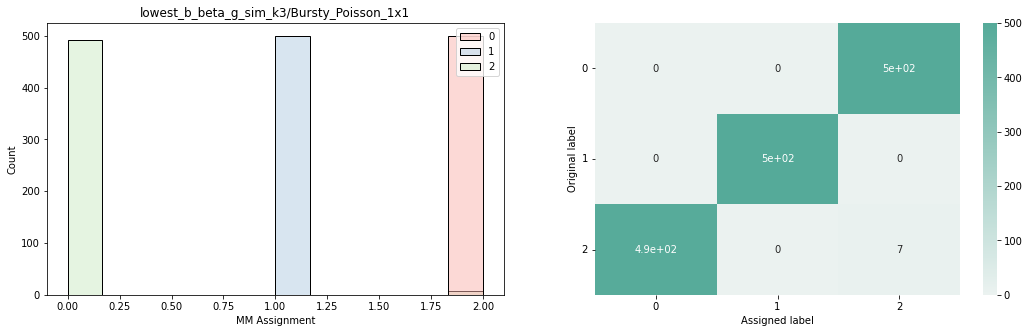

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(4, 4)


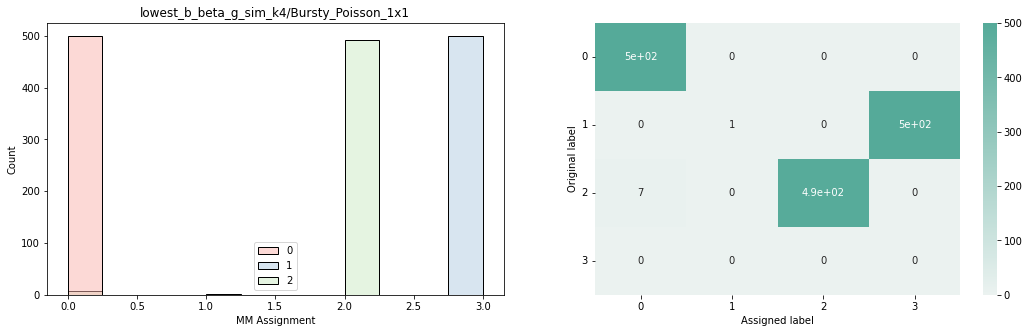

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(5, 5)
(5, 5)


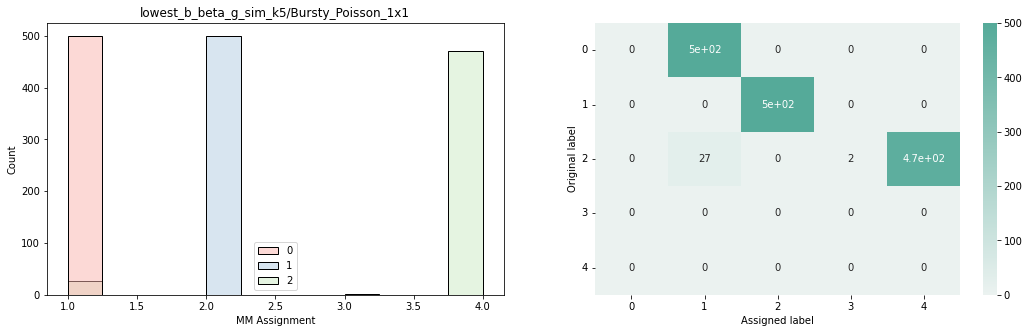

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


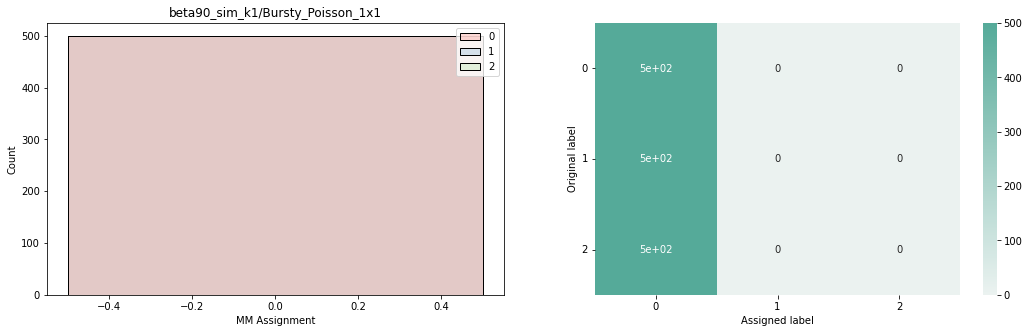

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


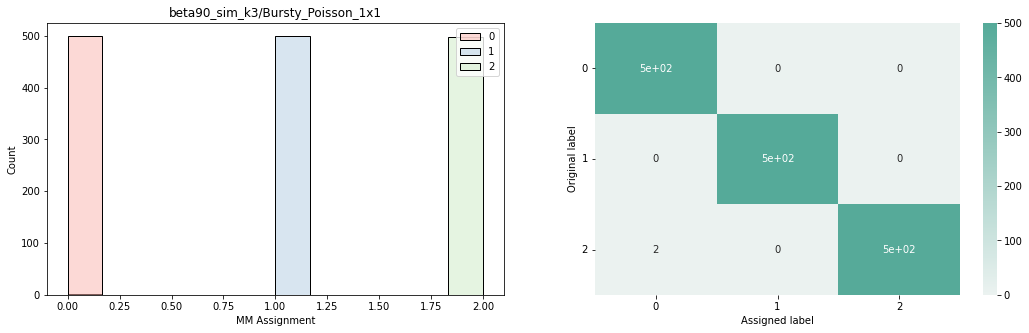

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(4, 4)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(5, 5)
(5, 5)


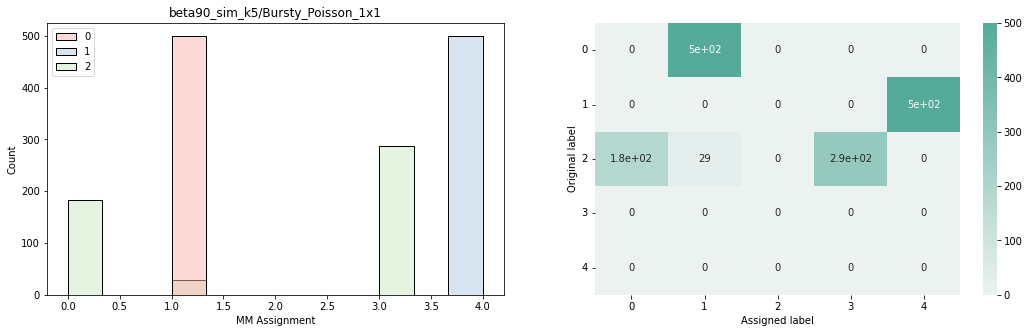

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


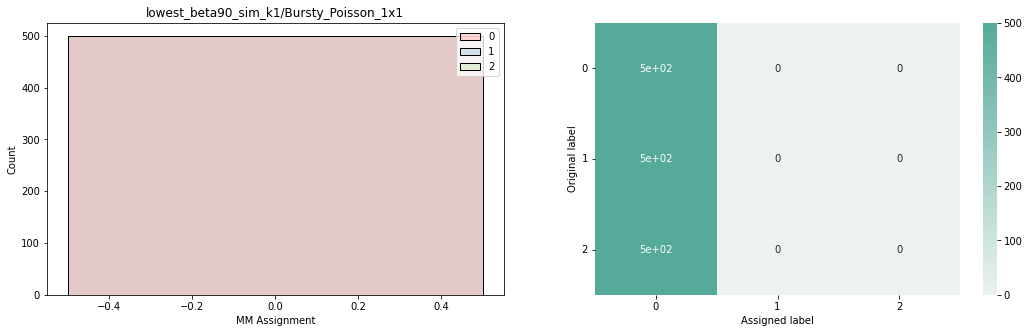

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


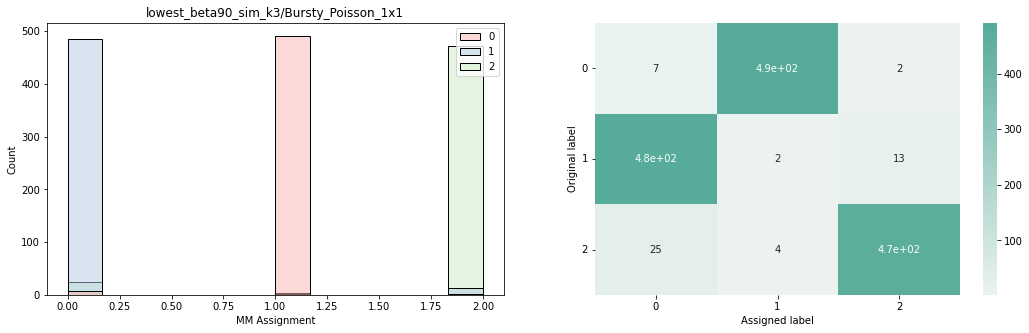

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(4, 4)


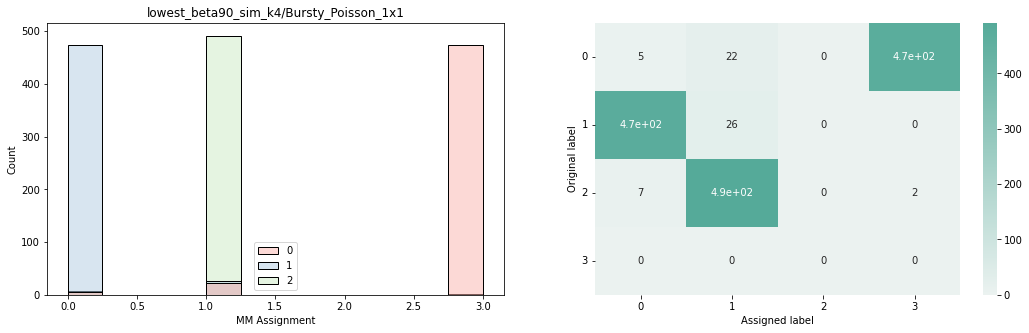

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(5, 5)
(5, 5)


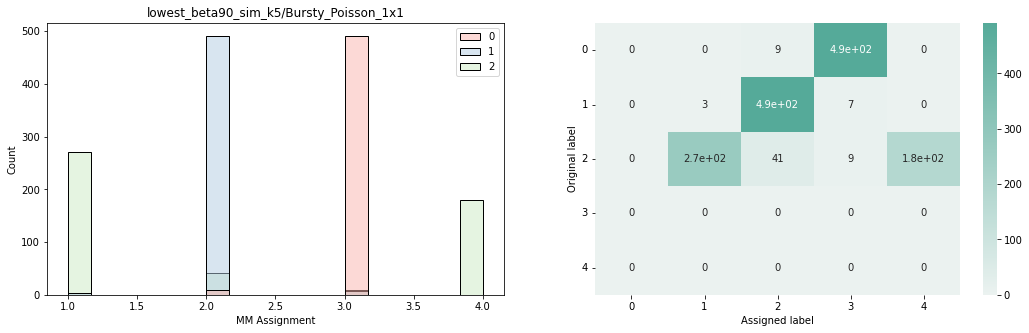

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


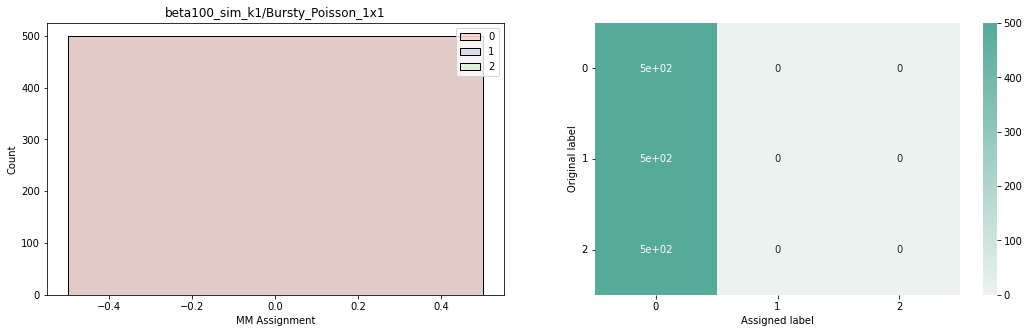

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


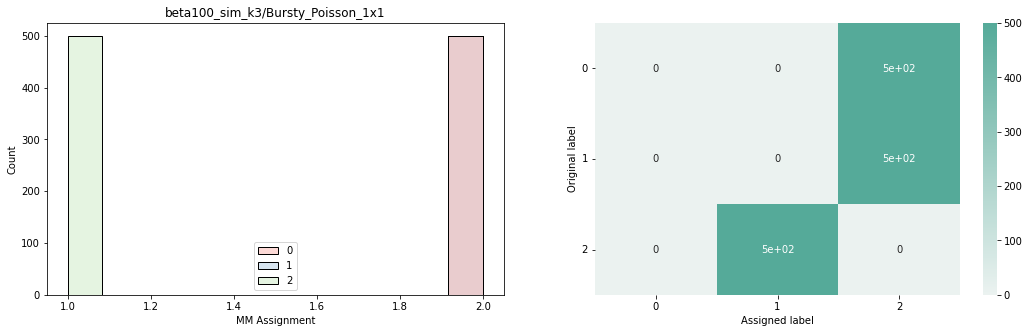

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(4, 4)


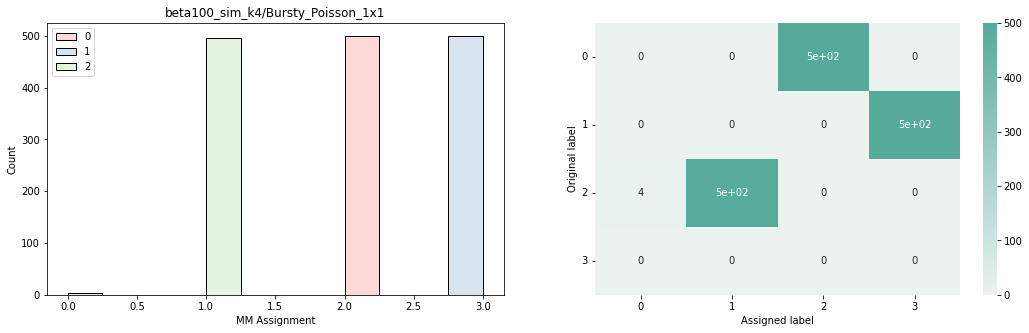

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(4, 4)


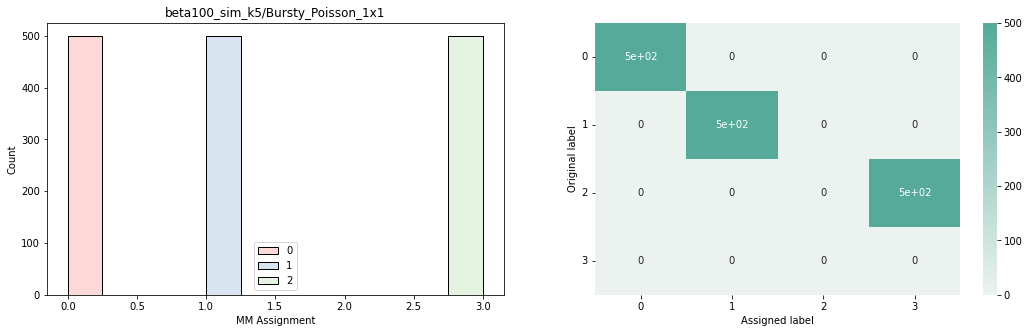

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


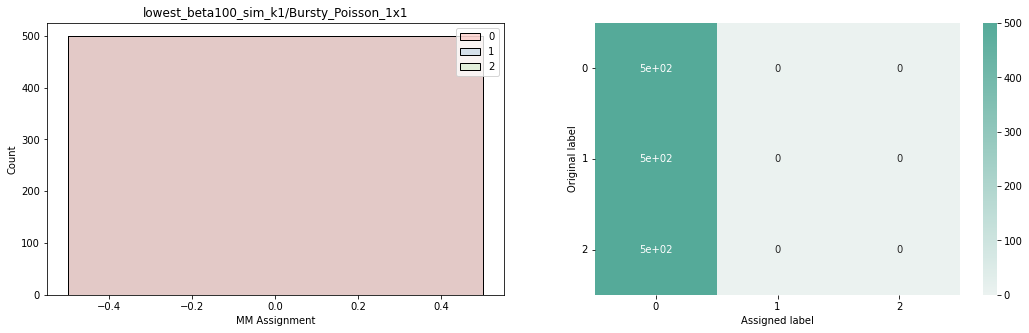

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


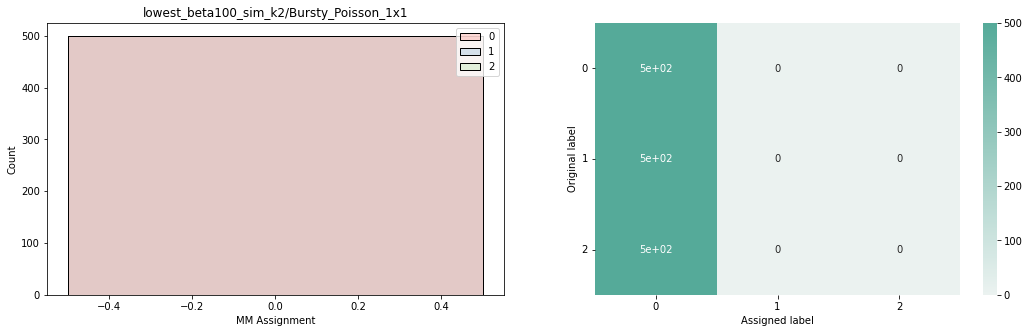

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(4, 4)


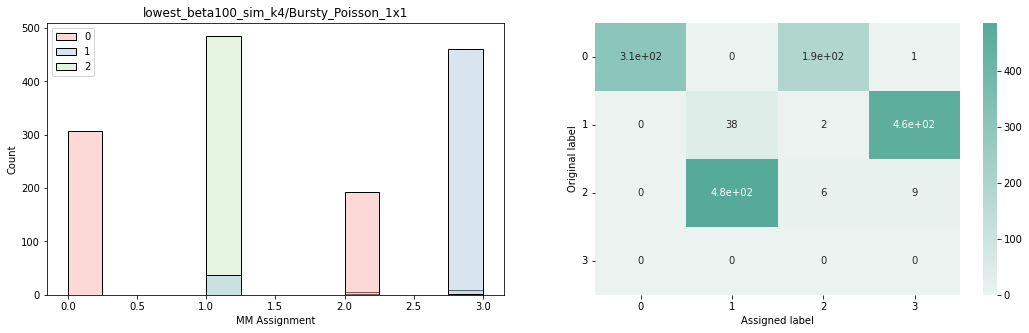

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(4, 4)


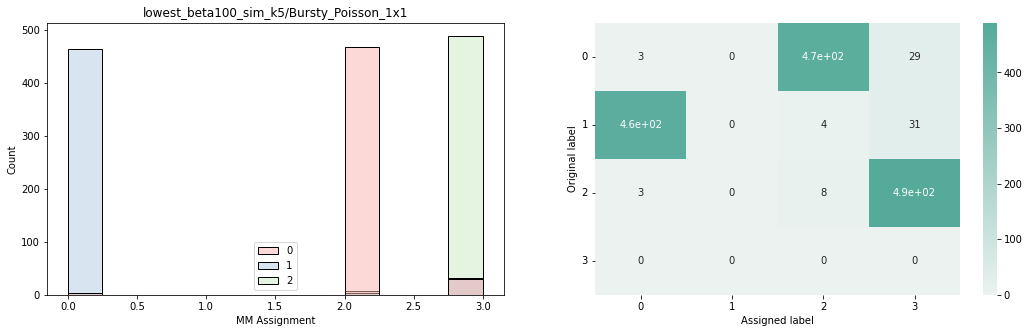

In [106]:
for r in grid_point_results:
    title = r.inference_string.replace('./fits/gg_230412_025_norman_crispr_MM_1/','')
    title = title.replcae('/Bursty_Poisson_1x1','')
    vis_assign(np.array(all_assigns_num),r.assigns,title)


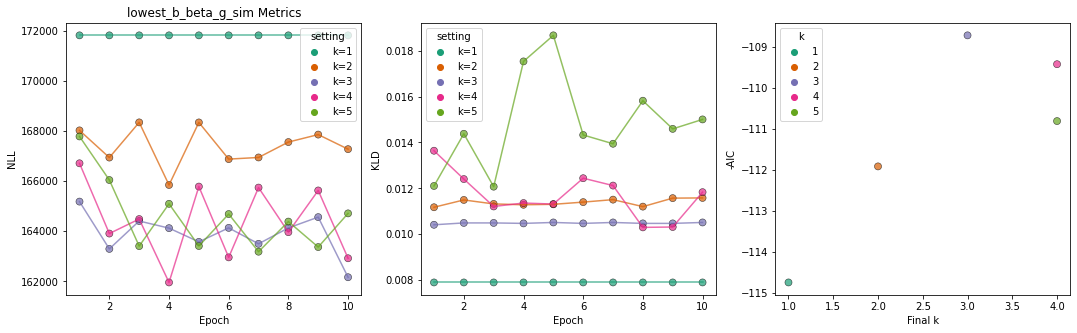

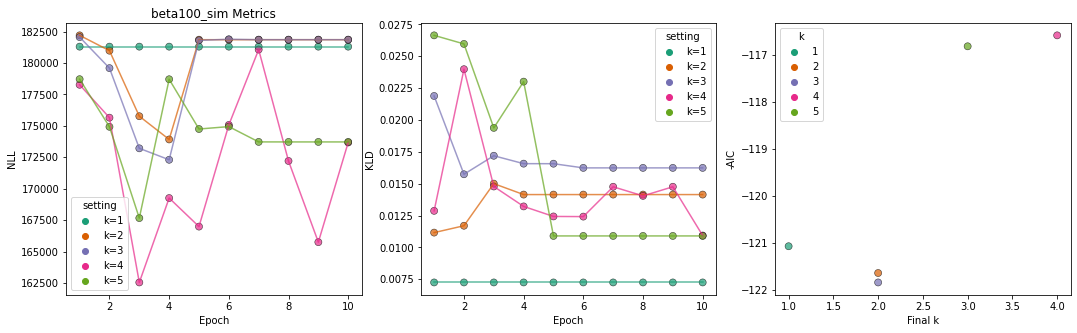

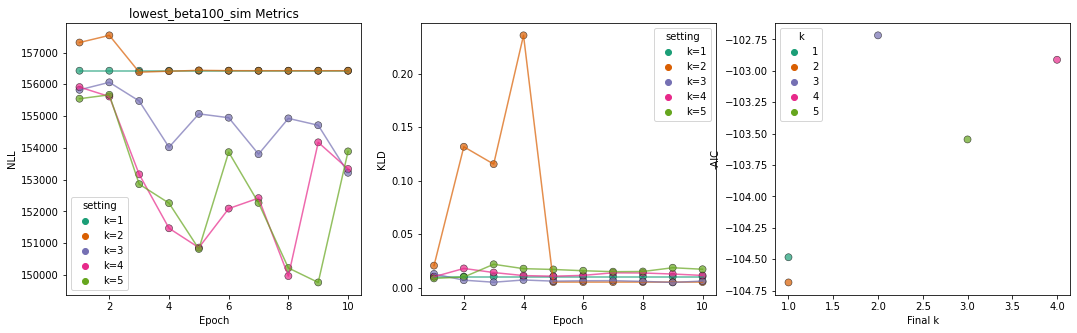

In [107]:
for i in range(0, len(grid_point_results), 5):
    r = grid_point_results[i:i+5]
    title = dataset_meta[i]+' Metrics'
    vis_metrics(r,title)